# Spray Vision Report Plots

This notebook generates and saves all requested plots using the processed dataset and trained models.

**Inputs:**
- time, chamb_pressure, cham_temp, injection_pres, density, viscosity

**Targets:**
- angle_mie, length_mie, angle_shadow, length_shadow

All plots will be saved in a dedicated `plots` folder in the project root.

In [1]:
# Journal-quality plotting config (Matplotlib + Seaborn)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Global rcParams
rc = {
    # Fonts
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],  # fallback if Arial missing
    "font.size": 7,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.titlesize": 7,

    # DPI and saving
    "figure.dpi": 400,
    "savefig.dpi": 400,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.01,

    # Lines and axes
    "lines.linewidth": 1.0,
    "axes.linewidth": 0.5,

    # Ticks
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.minor.size": 1.5,
    "ytick.minor.size": 1.5,
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.minor.width": 0.5,

    # Grid (thin lines for whitegrid)
    "grid.linewidth": 0.3,
}

mpl.rcParams.update(rc)

# Seaborn theme to match rcParams
sns.set_theme(context="paper", style="whitegrid", rc=rc)

# Helper: create figures using millimeter dimensions
# Example: fig_mm(85, 70) for a typical single-column figure

def fig_mm(width_mm=85, height_mm=70, nrows=1, ncols=1, **kwargs):
    inches = (width_mm / 25.4, height_mm / 25.4)
    return plt.subplots(nrows=nrows, ncols=ncols, figsize=inches, constrained_layout=True, **kwargs)

# Other imports and setup
import os
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Ensure plots folder exists
os.makedirs("plots", exist_ok=True)


ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# --- Define Figure Sizes ---
# Standard single-column width (approx 3.5 in)
SINGLE_COL_WIDTH = 3.5
# Standard 1.5 column width
ONE_FIVE_COL_WIDTH = 5.5
# Standard double-column width (approx 7 in)
DOUBLE_COL_WIDTH = 7

# Get figsize with a specific aspect ratio
def get_figsize(width_inches, aspect_ratio=(1.618)): # Golden ratio default
    return (width_inches, width_inches / aspect_ratio)

In [ ]:
df = pd.read_csv("data/processed/preprocessed_dataset.csv")

rename_map = {
    "Time_ms": "time",
    "Pc_bar": "chamb_pressure",
    "Tc_K": "cham_temp",
    "Pinj_bar": "injection_pres",
    "rho_kgm3": "density",
    "mu_Pas": "viscosity",
    "angle_shadow_deg": "angle_shadow",
    "len_shadow_L_D": "length_shadow",
    "angle_mie_deg": "angle_mie",
    "len_mie_L_D": "length_mie",
}

df = df.rename(columns=rename_map)
INPUTS = ["time", "chamb_pressure", "cham_temp", "injection_pres", "density", "viscosity"]
TARGETS = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]

print(f"Dataset Loaded. Shape: {df.shape}")

Dataset Loaded. Shape: (726, 11)


## 1. Time-dependent spray angle and spray length (Shadowgraph and Mie) for one experimental run

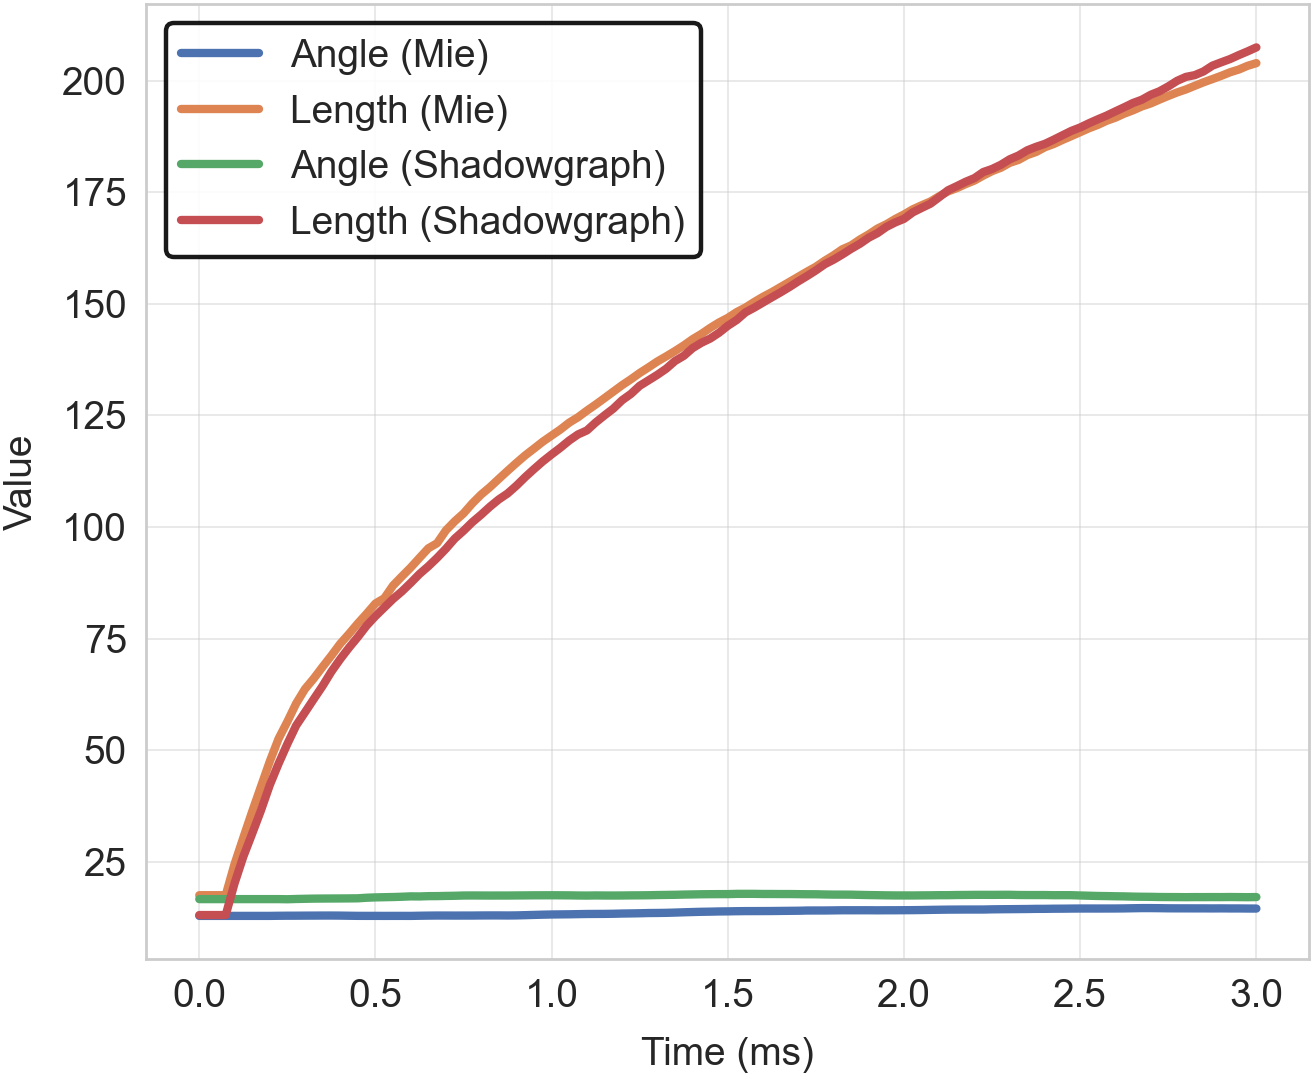

In [ ]:
run_df = df.iloc[:121]
fig, ax = fig_mm(85, 70)
ax.plot(run_df["time"], run_df["angle_mie"], label="Angle (Mie)", linewidth=1.5)
ax.plot(run_df["time"], run_df["length_mie"], label="Length (Mie)", linewidth=1.5)
ax.plot(run_df["time"], run_df["angle_shadow"], label="Angle (Shadowgraph)", linewidth=1.5)
ax.plot(run_df["time"], run_df["length_shadow"], label="Length (Shadowgraph)", linewidth=1.5)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Value")
ax.grid(True, alpha=0.5)
ax.legend(frameon=True, edgecolor='black', framealpha=0.9)
fig.savefig("plots/1_time_dependent_spray_angle_length.png")
plt.show()

## 2. Scatter plots: Chamber Temperature vs Angle (Mie), Chamber Pressure vs Angle (Shadowgraph)

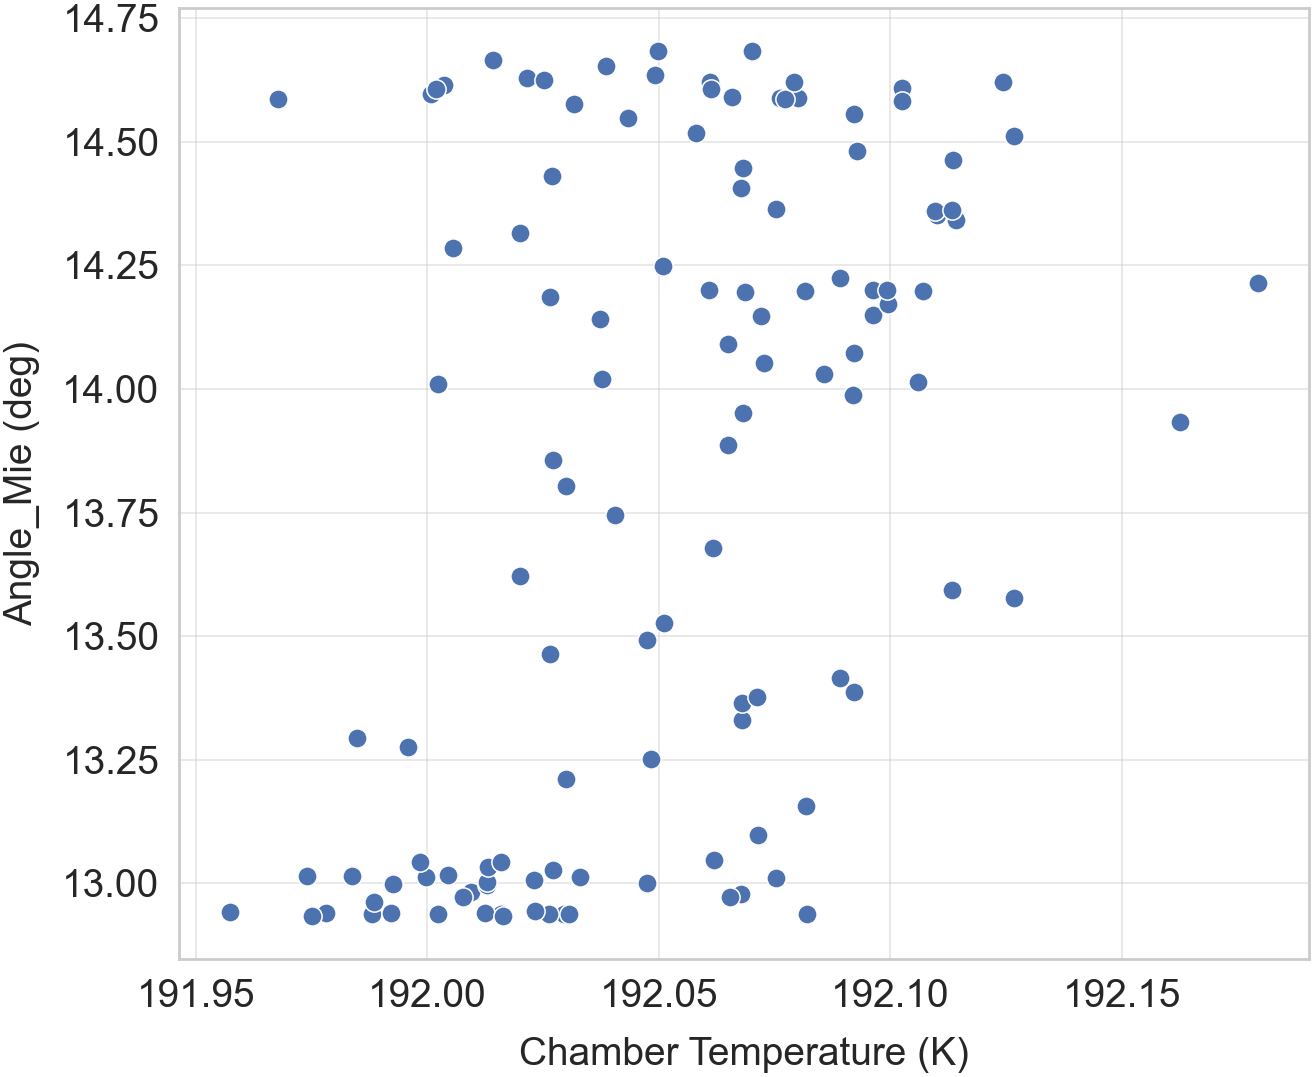

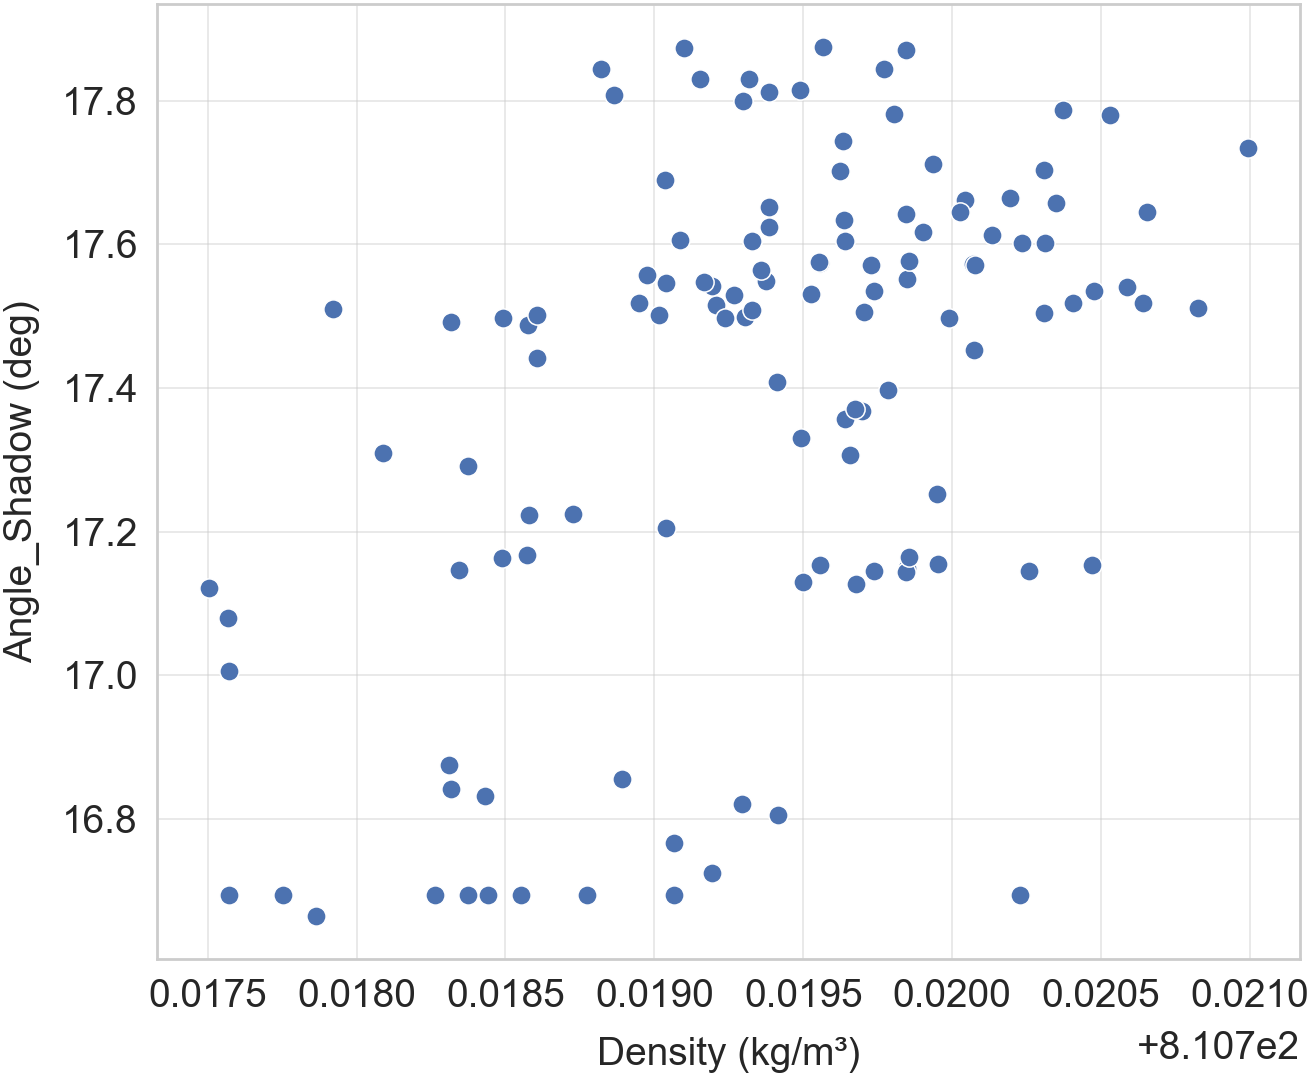

In [ ]:
fig, ax = fig_mm(85, 70)
sns.scatterplot(x="cham_temp", y="angle_mie", data=run_df, ax=ax, s=12)
ax.set_xlabel("Chamber Temperature (K)")
ax.set_ylabel("Angle_Mie (deg)")
ax.grid(True, alpha=0.5)
fig.savefig("plots/2a_cham_temp_vs_angle_mie.png")
plt.show()

fig, ax = fig_mm(85, 70)
sns.scatterplot(x="density", y="angle_shadow", data=run_df, ax=ax, s=12)
ax.set_xlabel("Density (kg/m³)")
ax.set_ylabel("Angle_Shadow (deg)")
ax.grid(True, alpha=0.5)
fig.savefig("plots/2b_density_vs_angle_shadow.png")
plt.show()


## 3. Correlation heatmap of features vs targets

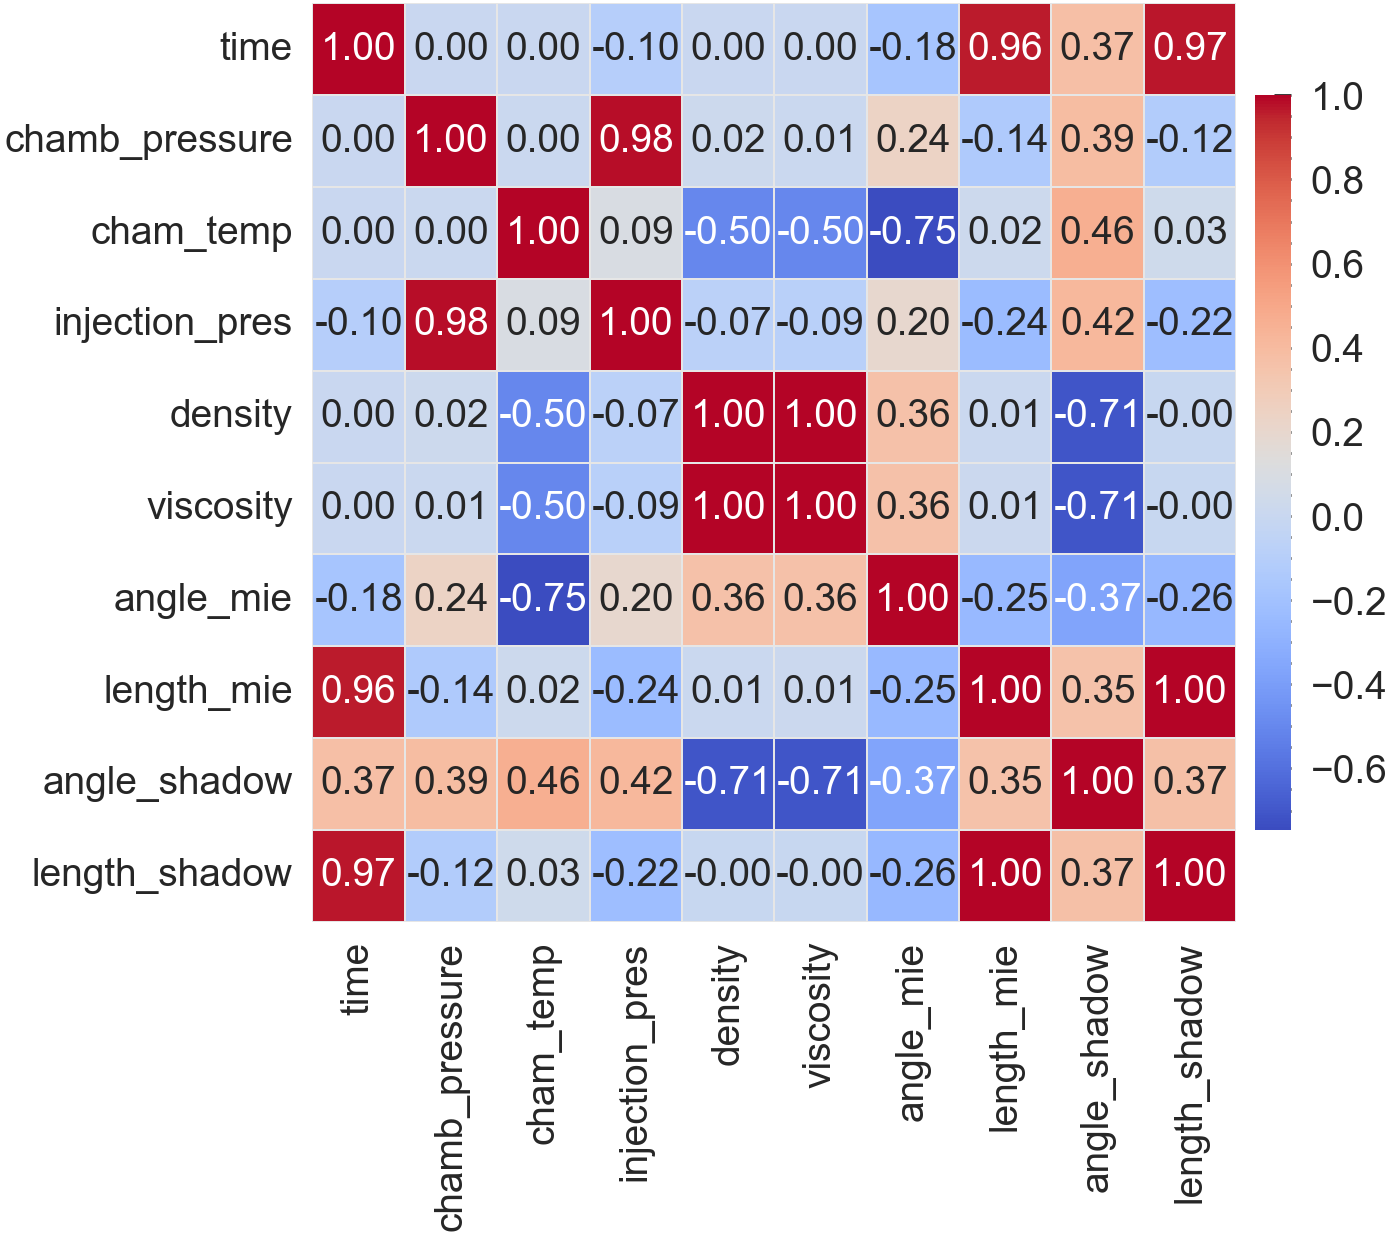

In [ ]:
corr = df[INPUTS + TARGETS].corr()
fig, ax = fig_mm(90, 80)
sns.heatmap(
    corr,
    ax=ax,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"shrink": 0.8, "pad": 0.02},
    linewidths=0.3,
    linecolor="0.9",
)
fig.savefig("plots/3_correlation_heatmap.png")
plt.show()

## 4. Predicted vs Actual values of best performing model for each target

In [ ]:
# Load and prepare data for Gradient Boosting model predictions
X = df[INPUTS].values
Y_shadow = df[["angle_shadow", "length_shadow"]].values
Y_mie = df[["angle_mie", "length_mie"]].values

# Split into train and test sets (80-20)
X_train, X_test, y_shadow_train, y_shadow_test, y_mie_train, y_mie_test = train_test_split(
    X, Y_shadow, Y_mie, test_size=0.2, random_state=42
)


# Function to generate predictions and return true vs predicted values using only Gradient Boosting model
def get_gb_predictions(X_tr, X_te, y_tr, y_te):
    gb_model_path = "models/GradientBoosting_regressor.joblib"
    gb_model = joblib.load(gb_model_path)
    gb_model.fit(X_tr, y_tr)
    y_pred = gb_model.predict(X_te)
    return y_te, y_pred


# Get predictions for both output sets
y_shadow_true, y_shadow_pred = get_gb_predictions(X_train, X_test, y_shadow_train, y_shadow_test)
y_mie_true, y_mie_pred = get_gb_predictions(X_train, X_test, y_mie_train, y_mie_test)

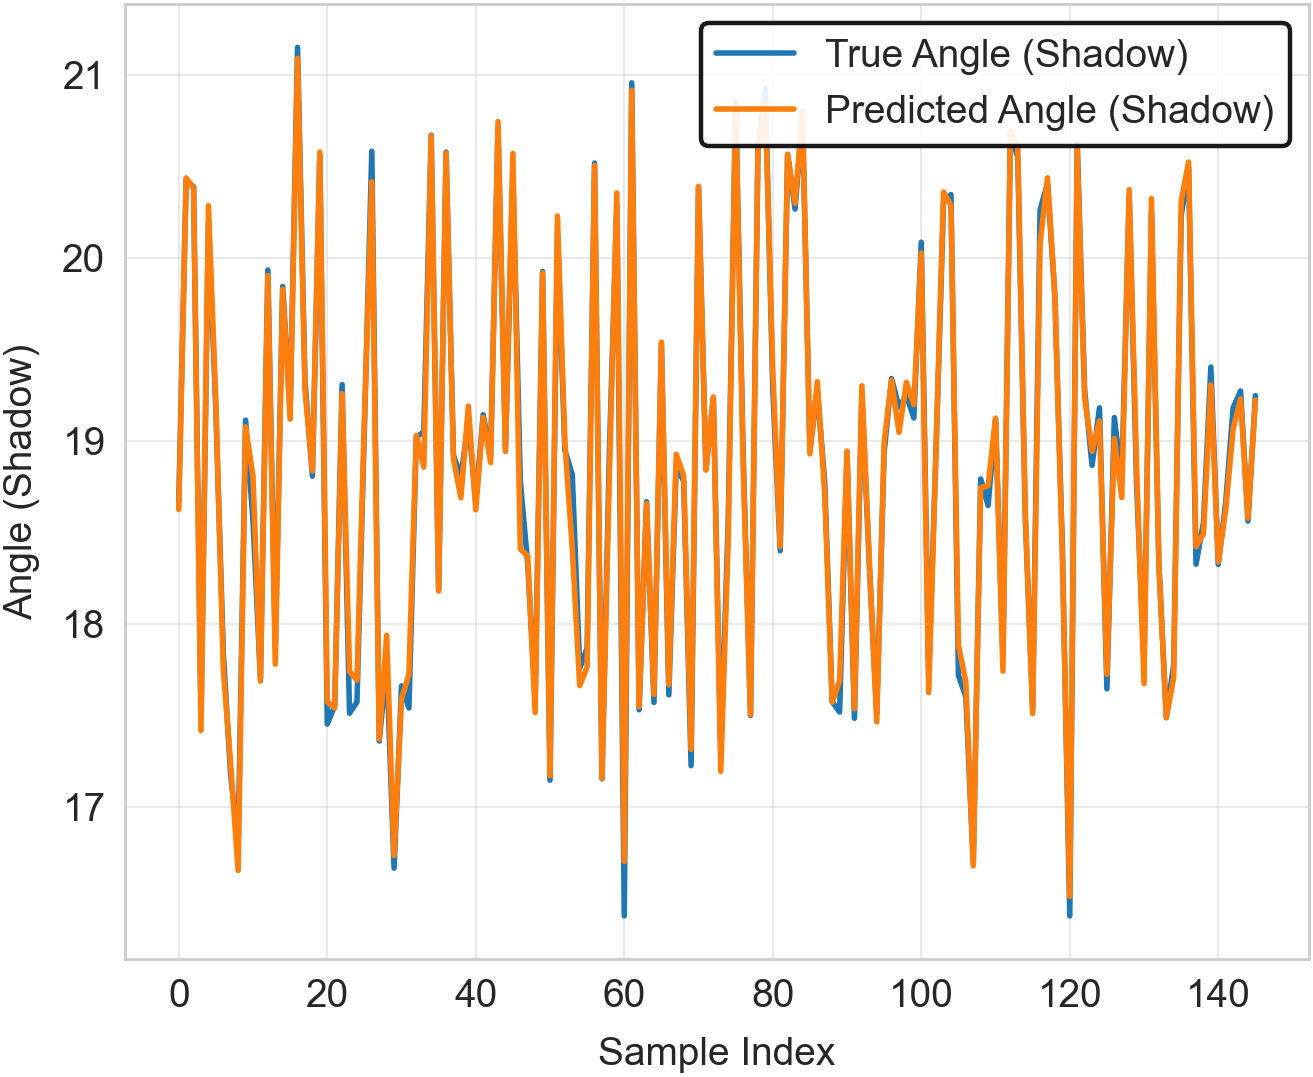

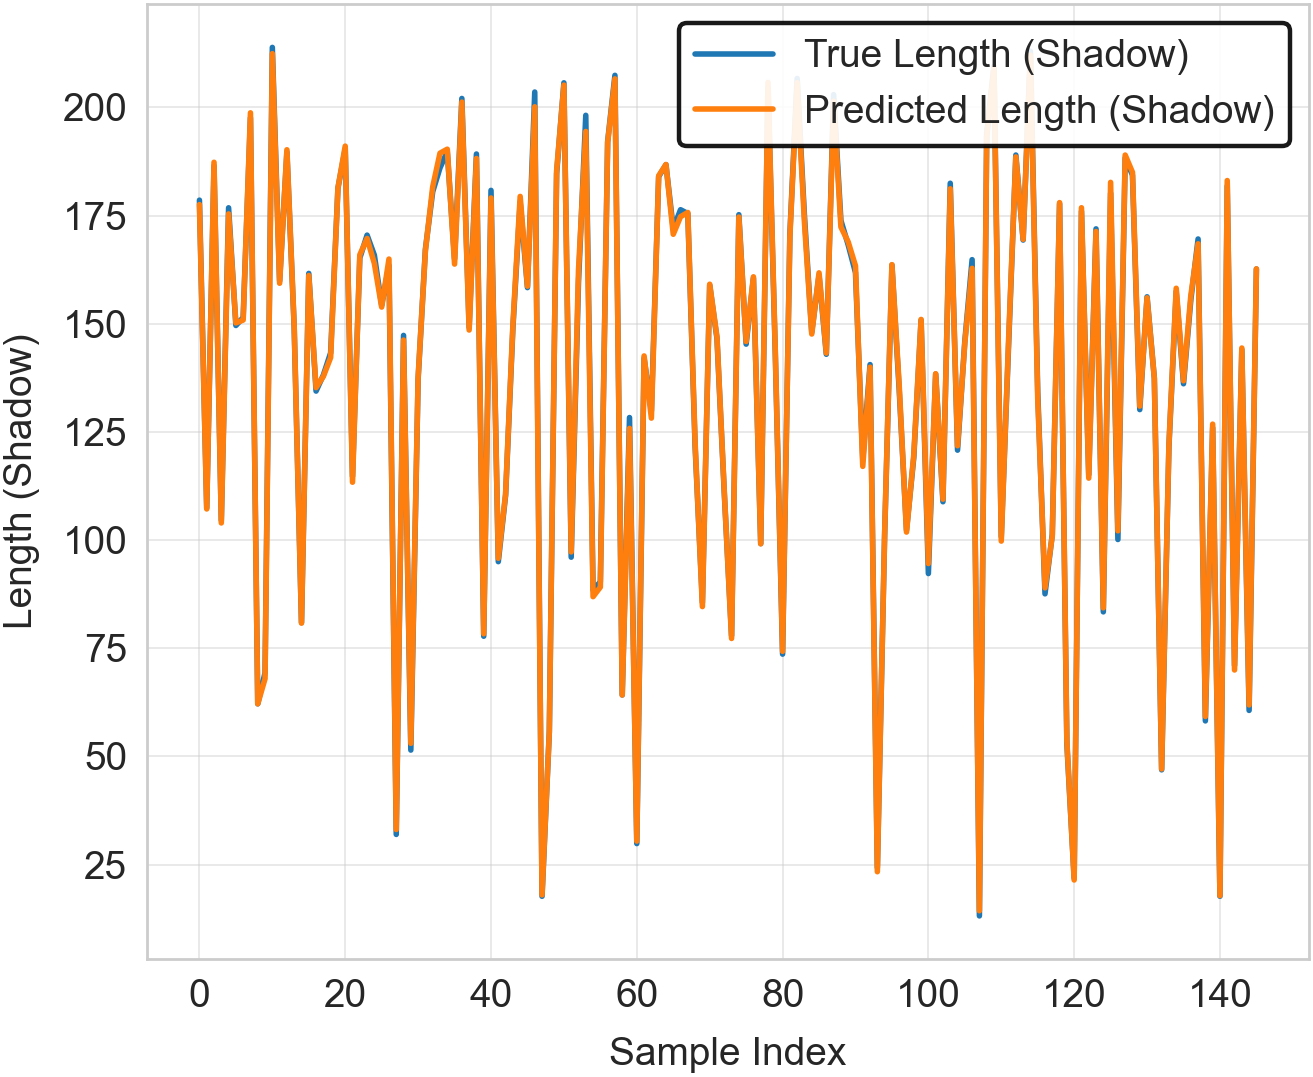

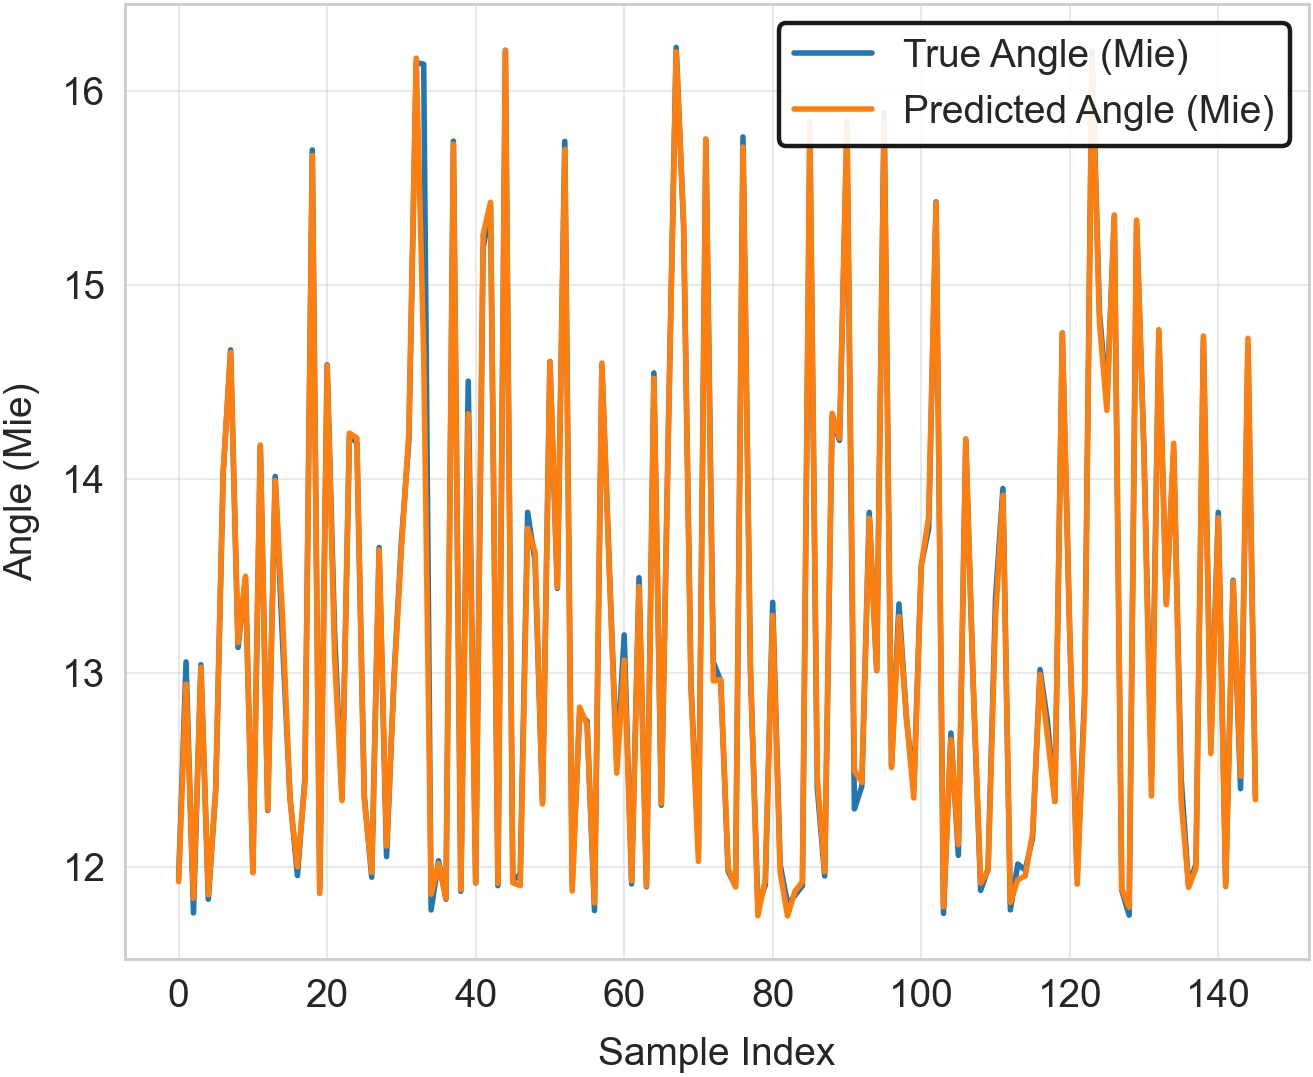

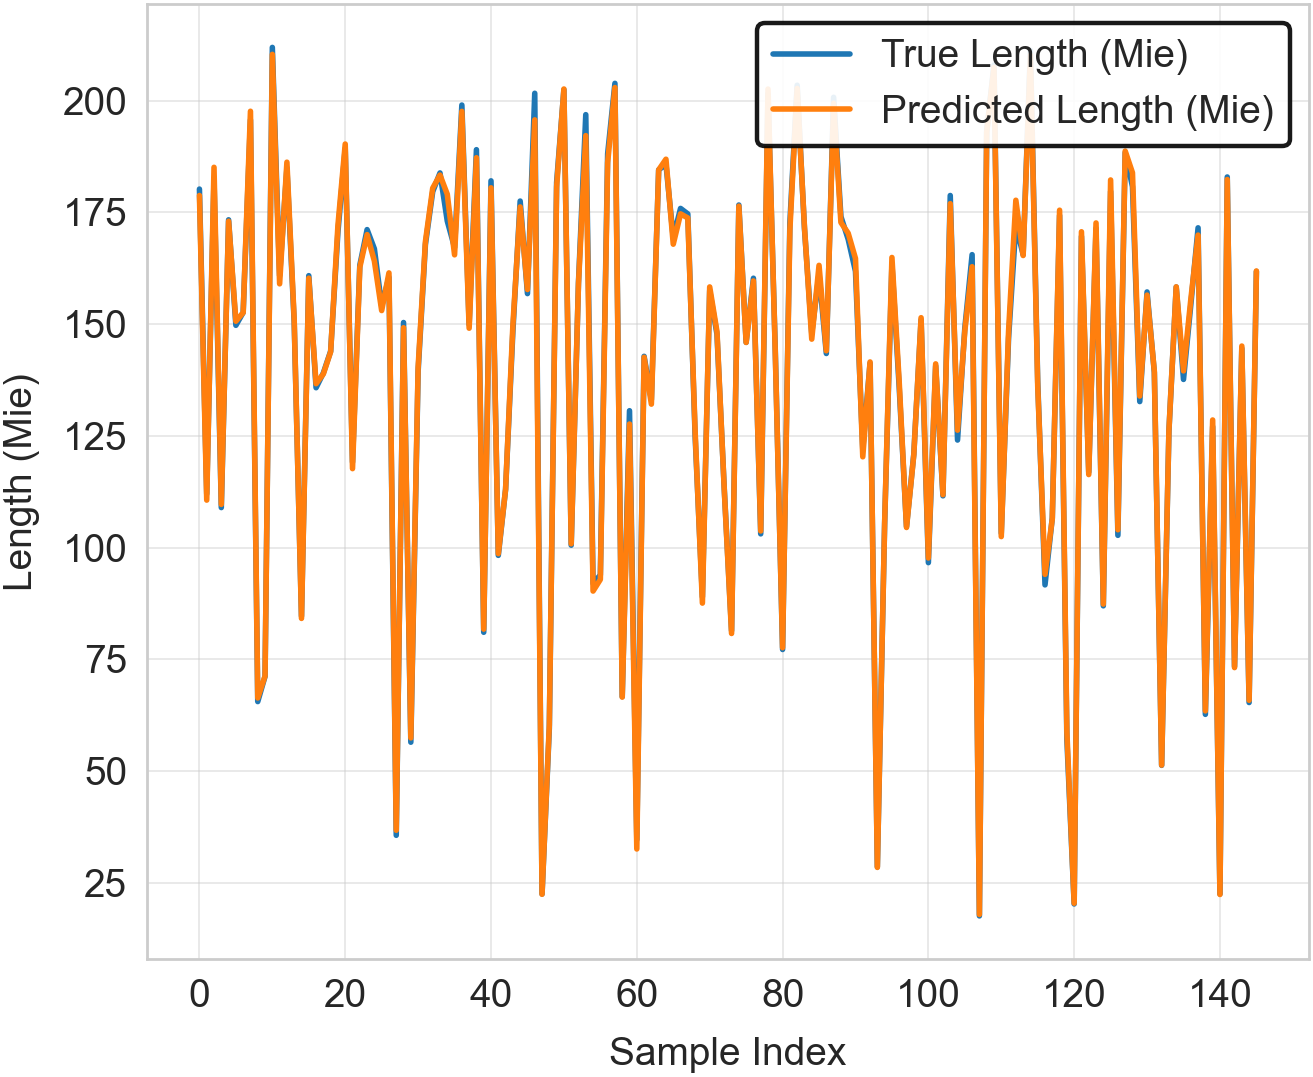

In [ ]:
# Function to plot and save individual time series for each variable (angle/length, shadow/mie)
def plot_individual_time_series_separate(y_true, y_pred, label):
    fig, ax = fig_mm(85, 70)
    ax.plot(y_true, label=f"True {label}", color="tab:blue")
    ax.plot(y_pred, label=f"Predicted {label}", color="tab:orange")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel(label)
    ax.grid(True, alpha=0.5)
    ax.legend(loc="upper right", frameon=True, edgecolor='black', framealpha=0.9)
    fig.savefig(f"plots/4_predicted_vs_actual_line_plot_for_{label}.png")
    plt.show()


# Shadow: angle & length
plot_individual_time_series_separate(y_shadow_true[:, 0], y_shadow_pred[:, 0], "Angle (Shadow)")
plot_individual_time_series_separate(y_shadow_true[:, 1], y_shadow_pred[:, 1], "Length (Shadow)")

# Mie: angle & length
plot_individual_time_series_separate(y_mie_true[:, 0], y_mie_pred[:, 0], "Angle (Mie)")
plot_individual_time_series_separate(y_mie_true[:, 1], y_mie_pred[:, 1], "Length (Mie)")


## 5. True vs Predicted values across all 6 ML models for each target

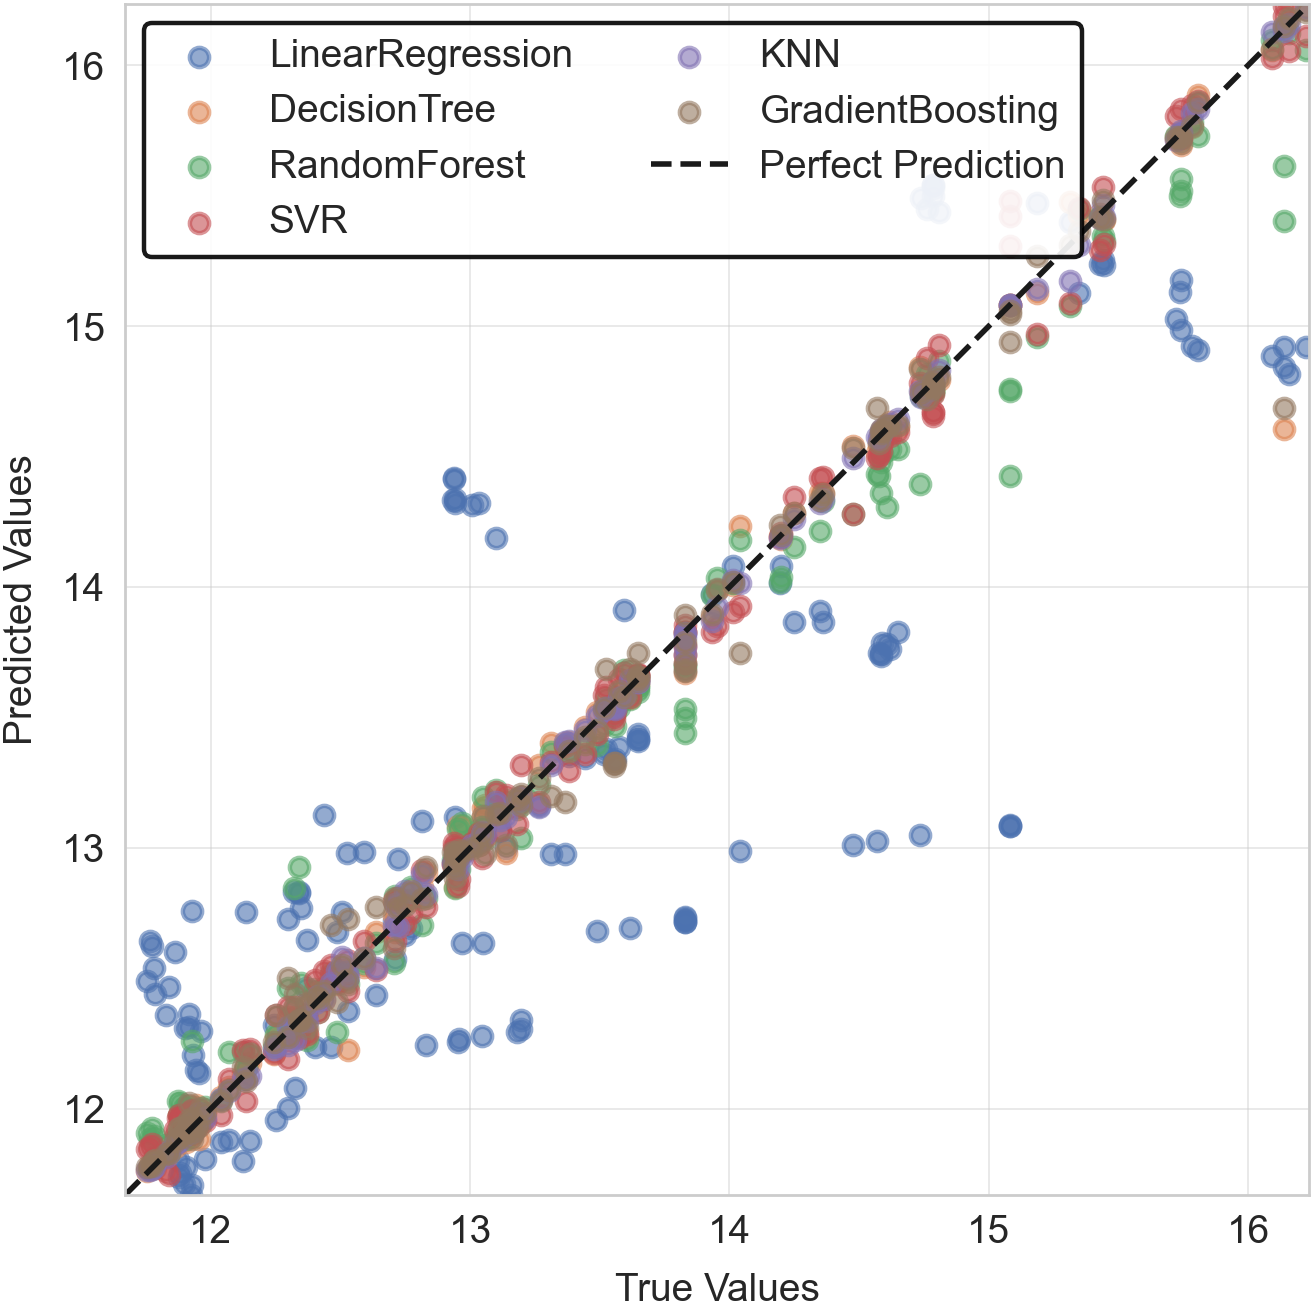

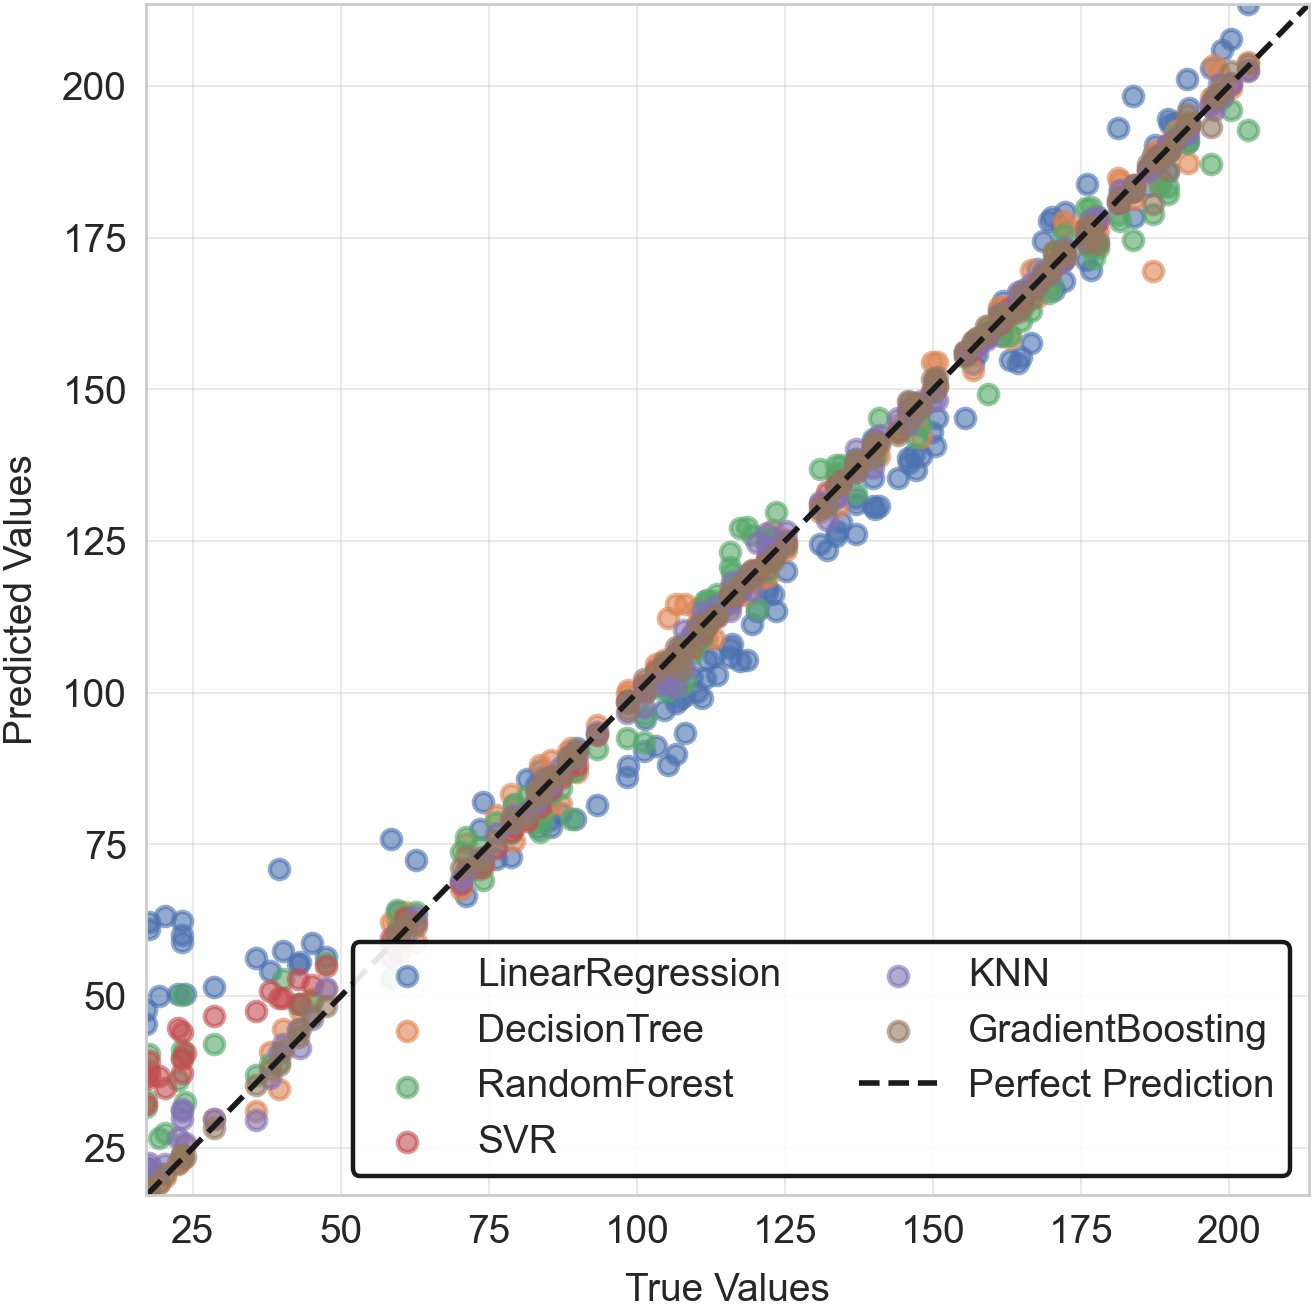

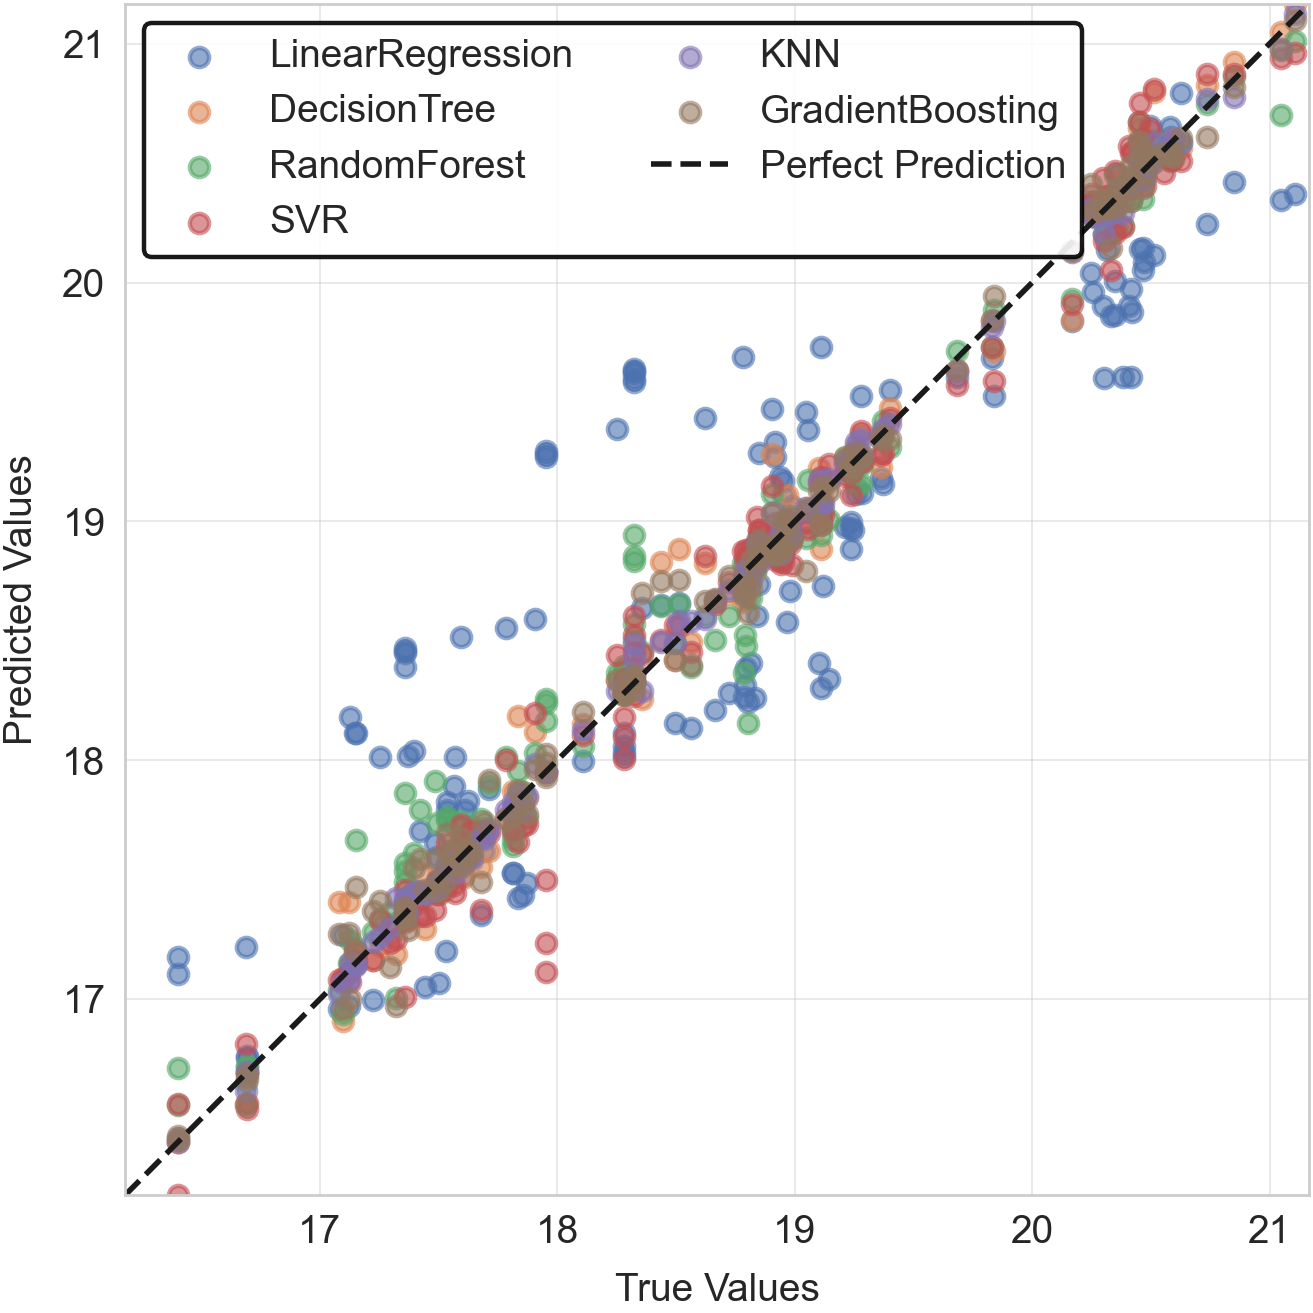

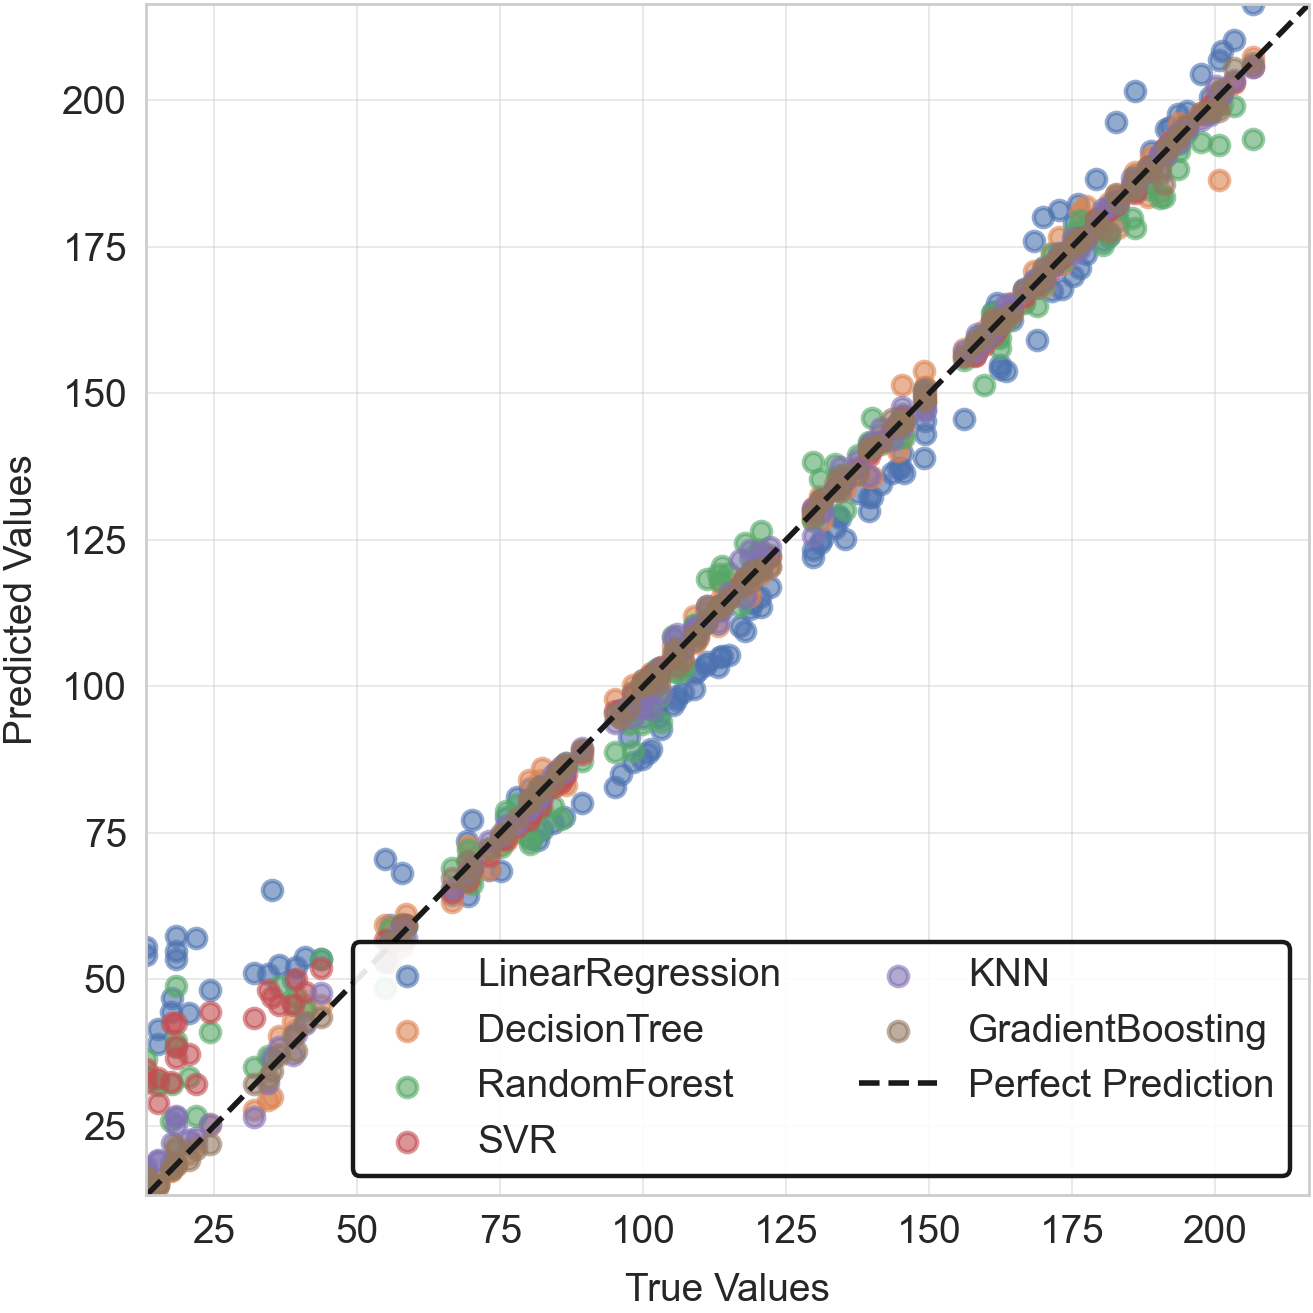

In [ ]:
X, y = df[INPUTS], df[TARGETS]
runs = df["run"]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=runs)

# List of model names to load
model_names = [
    "LinearRegression",
    "DecisionTree",
    "RandomForest",
    "SVR",
    "KNN",
    "GradientBoosting",
]

# Iterate through each target variable
for target_index, target in enumerate(TARGETS):
    fig, ax = fig_mm(85, 85)  # Square parity plot

    all_preds = []
    # Iterate through each trained model
    for mdl_name in model_names:
        model_path = f"models/{mdl_name}_regressor.joblib"
        if os.path.exists(model_path):
            model = joblib.load(model_path)
            y_pred = model.predict(X_te)[:, target_index]  # Get predictions for the current target
            all_preds.append(y_pred)
            ax.scatter(y_te[target], y_pred, label=mdl_name, alpha=0.6, s=12)
        else:
            print(f"Model {mdl_name} not found.")

    # Add a diagonal line for reference
    if all_preds:
        y_true_vals = y_te[target].values
        y_pred_concat = np.concatenate(all_preds)
        max_val = max(y_true_vals.max(), y_pred_concat.max())
        min_val = min(y_true_vals.min(), y_pred_concat.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1.0, label="Perfect Prediction")
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)

    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.legend(ncols=2, frameon=True, edgecolor='black', framealpha=0.9)
    ax.grid(True, alpha=0.5)
    fig.savefig(f"plots/5_parity_plot_for_{target}.png")
    plt.show()

## 6. Residual analysis for Angle (Mie)

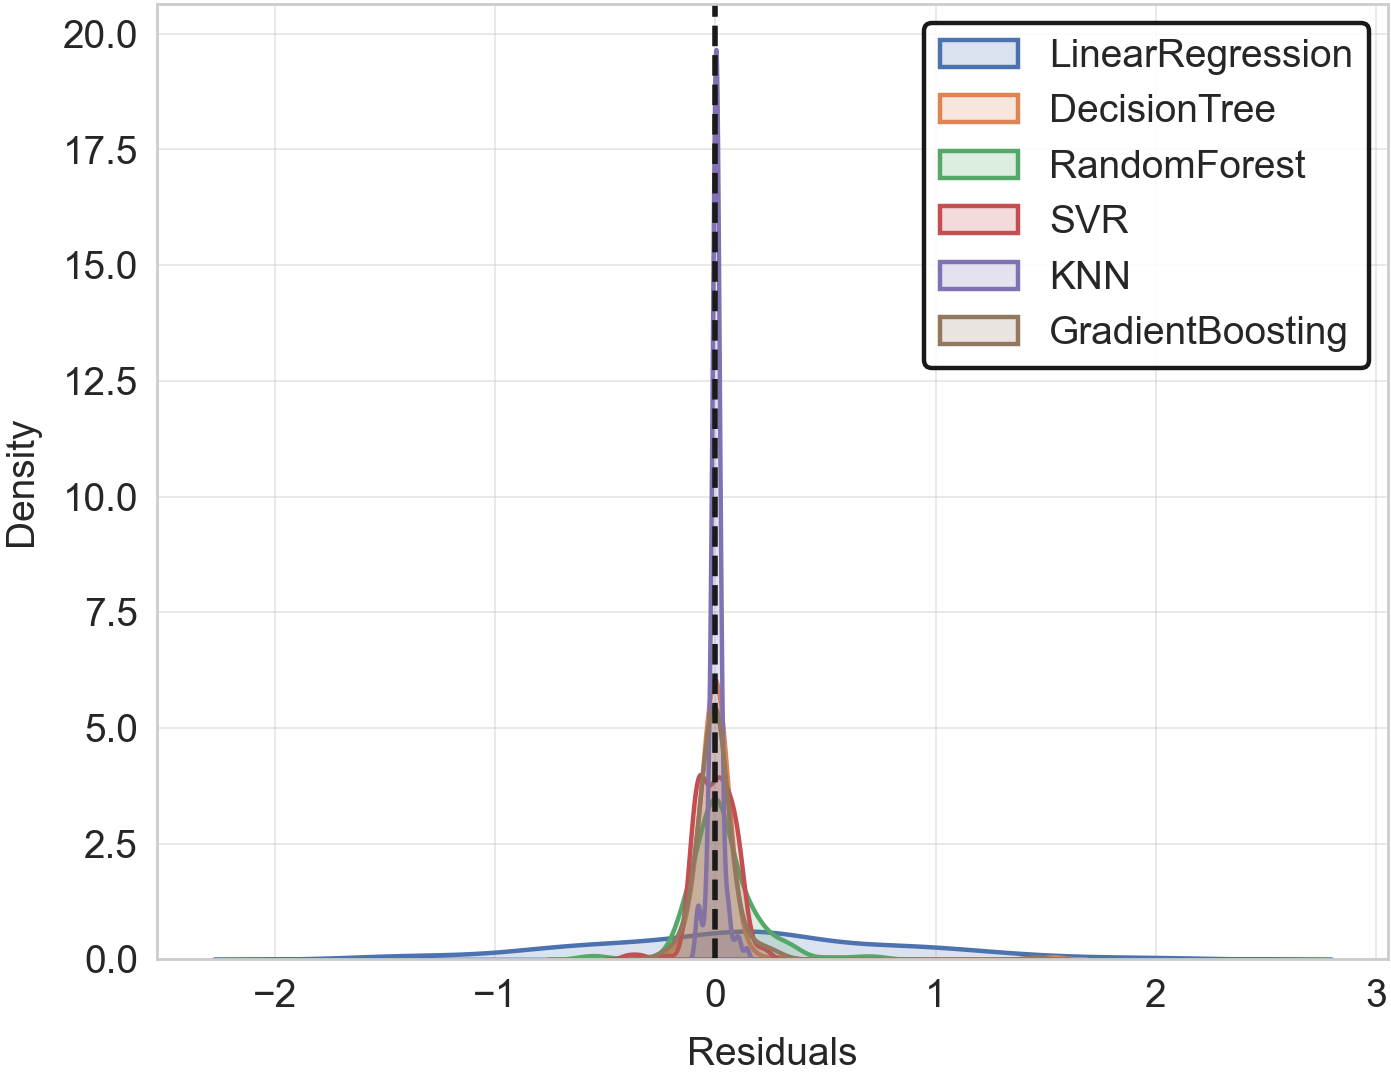

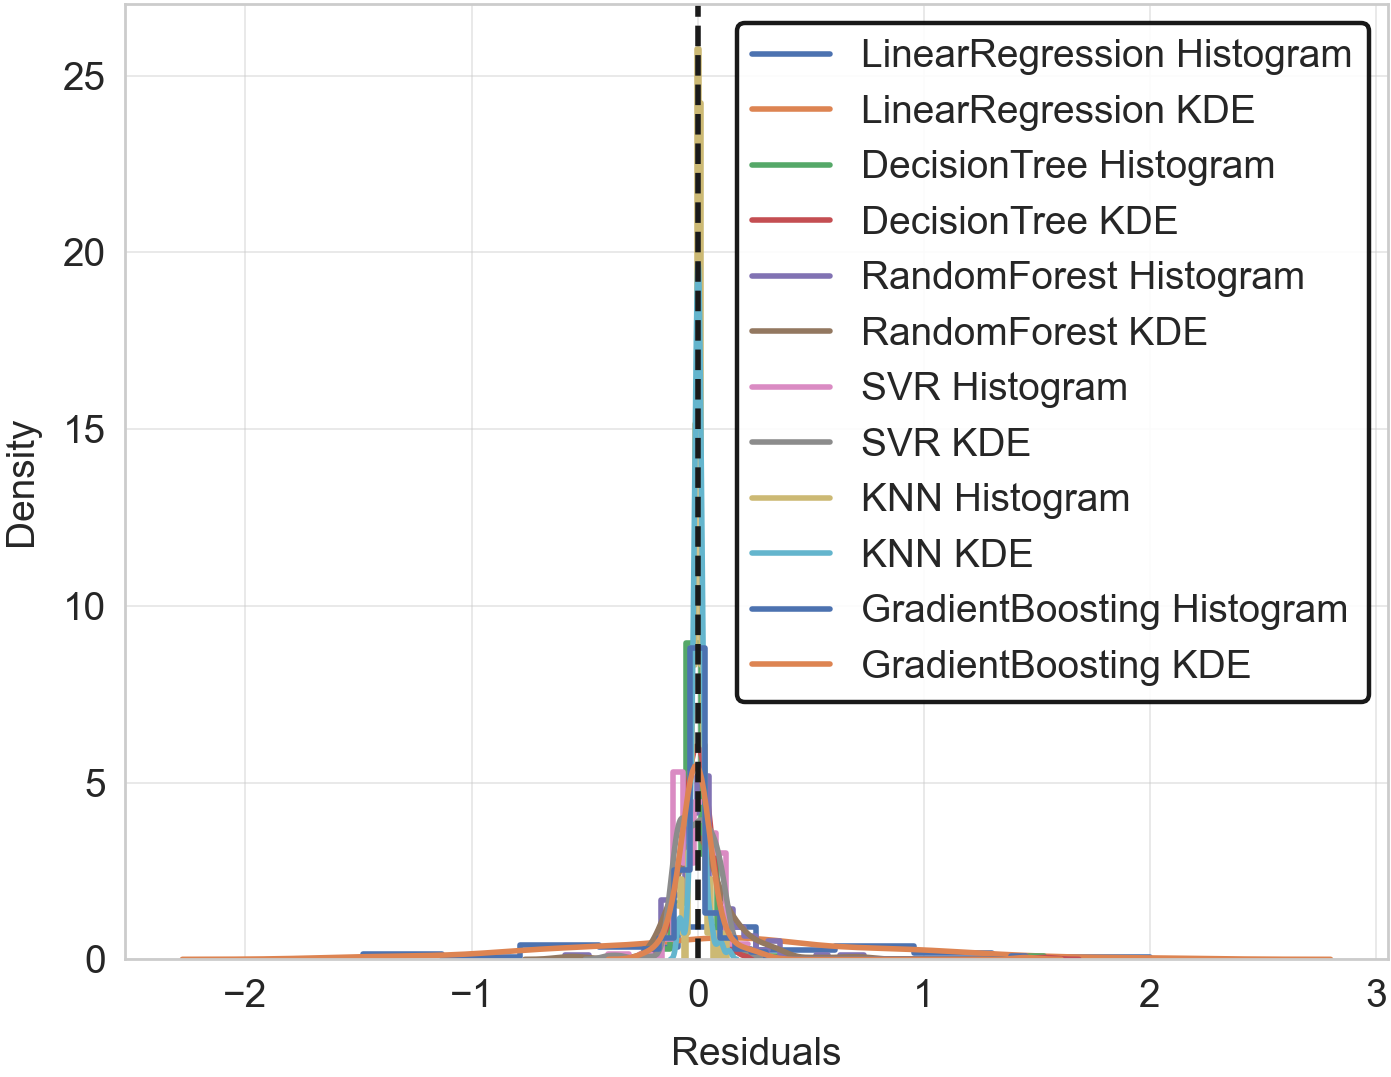

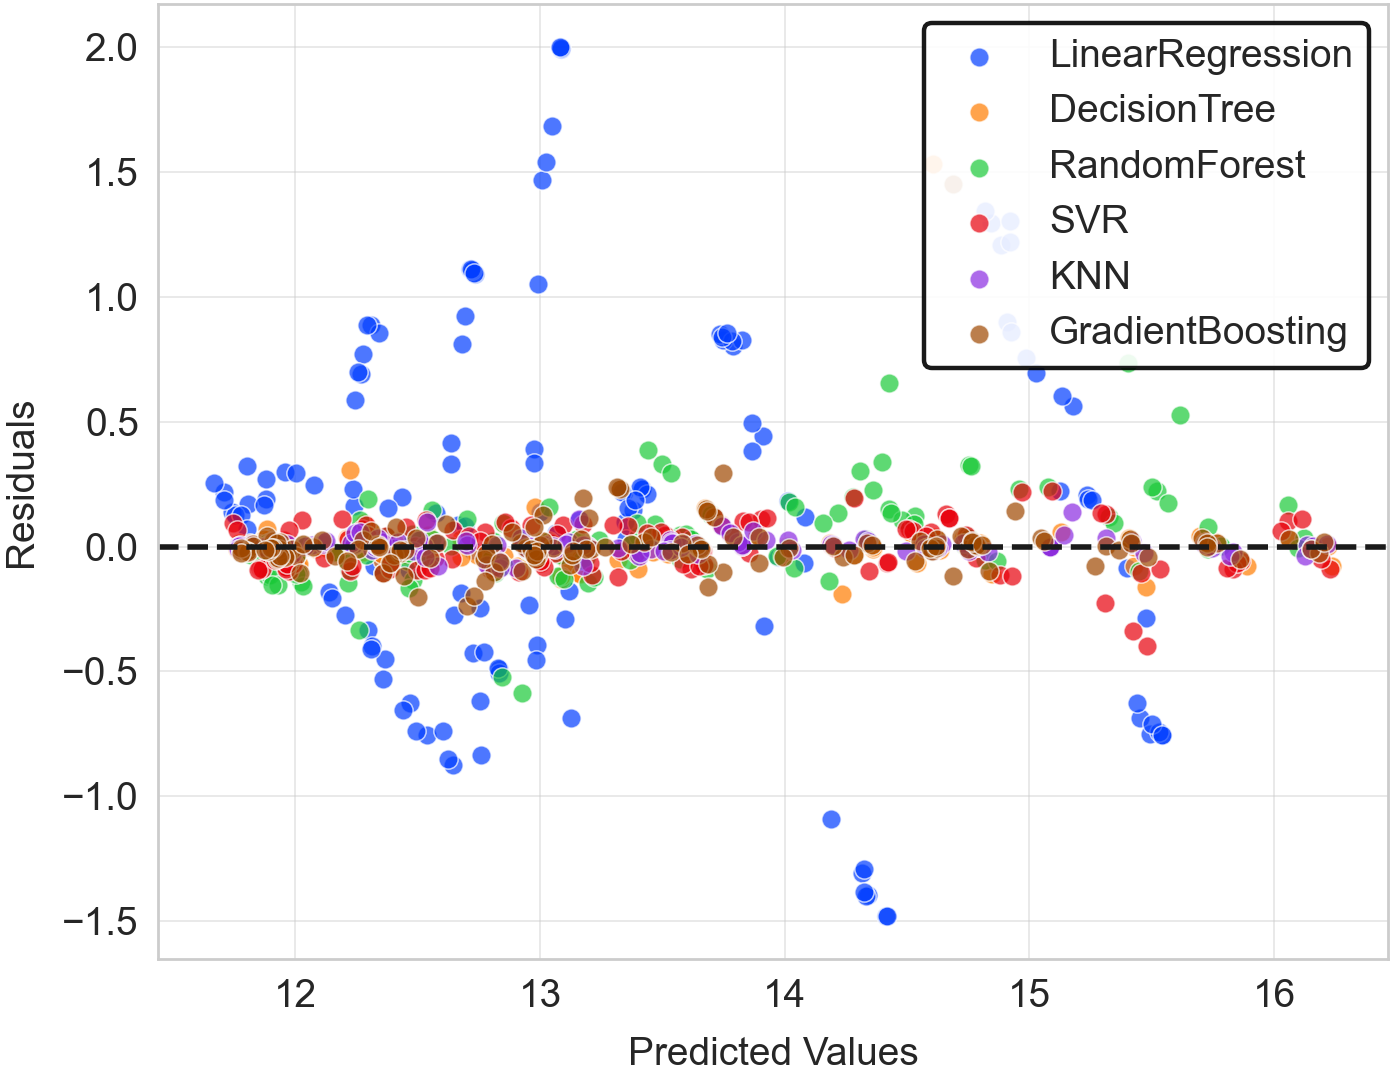

In [ ]:
TARGET_FOR_ANALYSIS = "angle_mie"

# Get the index of our target variable for slicing model outputs
target_index = TARGETS.index(TARGET_FOR_ANALYSIS)
# Get the true values for our specific target
y_te_target = y_te[TARGET_FOR_ANALYSIS]

results = {}

for mdl_name in model_names:
    model_path = f"models/{mdl_name}_regressor.joblib"
    if os.path.exists(model_path):
        model = joblib.load(model_path)

        # Make predictions on the test set
        y_pred_all = model.predict(X_te)

        # Isolate predictions for the specific target
        y_pred_target = y_pred_all[:, target_index]

        # Calculate residuals (error)
        residuals = y_te_target - y_pred_target

        # Store results for plotting
        results[mdl_name] = {"predictions": y_pred_target, "residuals": residuals}
    else:
        print(f"Warning: Model file not found at {model_path}. Skipping {mdl_name}.")


# Plot 1: KDE Residual Plots
fig, ax1 = fig_mm(90, 70)
for name, data in results.items():
    sns.kdeplot(data["residuals"], ax=ax1, label=name, fill=True, alpha=0.2)
ax1.axvline(x=0, color="k", linestyle="--", linewidth=1.0)
ax1.set_xlabel("Residuals")
ax1.set_ylabel("Density")
ax1.legend(frameon=True, edgecolor='black', framealpha=0.9)
ax1.grid(True, alpha=0.5)
fig.savefig("plots/6a_kde_residuals_angle_mie.png")
plt.show()


# Plot 2: Histogram and KDE Overlays
fig, ax2 = fig_mm(90, 70)
for name, data in results.items():
    sns.histplot(
        data["residuals"],
        ax=ax2,
        label=f"{name} Histogram",
        stat="density",
        element="step",
        fill=False,
    )
    sns.kdeplot(data["residuals"], ax=ax2, label=f"{name} KDE")
ax2.axvline(x=0, color="k", linestyle="--", linewidth=1.0)
ax2.set_xlabel("Residuals")
ax2.set_ylabel("Density")
# Consolidate legends by creating a single legend from all plot elements
handles, labels = ax2.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax2.legend(unique_labels.values(), unique_labels.keys(), frameon=True, edgecolor='black', framealpha=0.9)
ax2.grid(True, alpha=0.5)
fig.savefig("plots/6b_hist_kde_residuals_angle_mie.png")
plt.show()


# Plot 3: Residuals vs. Predicted Values
fig, ax3 = fig_mm(90, 70)
# Use a color palette for better distinction
palette = sns.color_palette("bright", len(results))
for i, (name, data) in enumerate(results.items()):
    sns.scatterplot(
        x=data["predictions"],
        y=data["residuals"],
        ax=ax3,
        label=name,
        alpha=0.7,
        color=palette[i],
        s=12,  # smaller markers for print
    )
ax3.axhline(y=0, color="k", linestyle="--", linewidth=1.0)
ax3.set_xlabel("Predicted Values")
ax3.set_ylabel("Residuals")
ax3.legend(frameon=True, edgecolor='black', framealpha=0.9)
ax3.grid(True, alpha=0.5)
fig.savefig("plots/6c_residuals_vs_predicted_angle_mie.png")
plt.show()

## 7. Feature importance bar chart for Random Forest model

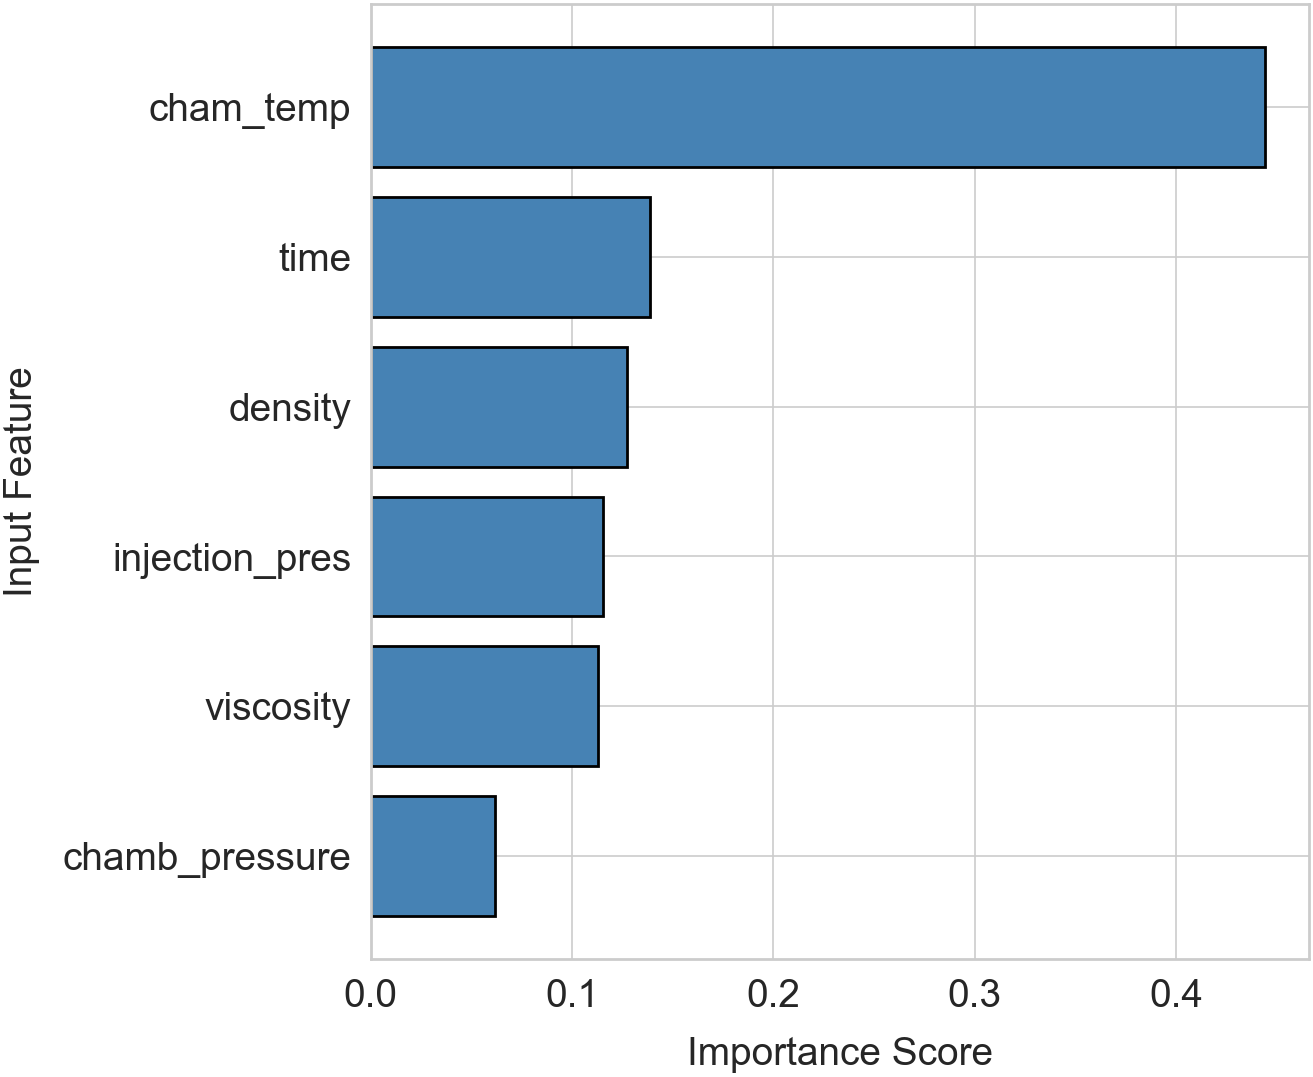

In [ ]:
notebook_dir = Path.cwd()
models_dir = notebook_dir / "models"
model_path = models_dir / "RandomForest_regressor.joblib"

rf_model = joblib.load(model_path)
multi_output_regressor = rf_model.named_steps["reg"]
estimators = multi_output_regressor.estimators_

feature_names = ["time", "chamb_pressure", "cham_temp", "injection_pres", "density", "viscosity"]
target_names = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]
rf_angle_mie = estimators[target_names.index("angle_mie")]

feature_importances = rf_angle_mie.feature_importances_
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values("Importance", ascending=False)
importance_df["Percentage"] = (
    importance_df["Importance"] / importance_df["Importance"].sum()
) * 100

fig, ax = fig_mm(85, 70)
ax.barh(
    importance_df["Feature"],
    importance_df["Importance"],
    color="steelblue",
    edgecolor="black",
    linewidth=0.5,
)
ax.set_xlabel("Importance Score")
ax.set_ylabel("Input Feature")
ax.invert_yaxis()
fig.savefig("plots/7_feature_importance_angle_mie_rf.png")
plt.show()

## 8. ANN vs best performing ML model: True vs Predicted plots for spray length/angle (Shadowgraph and Mie)

In [ ]:
ann_actuals = pd.read_csv("outputs/ANN_improved_actuals.csv")
ann_predictions = pd.read_csv("outputs/ANN_improved_predictions.csv")

gb_model = joblib.load("models/GradientBoosting_regressor.joblib")
runs = df["run"]
X, y = df[INPUTS], df[TARGETS]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=runs)
gb_predictions = gb_model.predict(X_te)
gb_predictions_df = pd.DataFrame(gb_predictions, columns=TARGETS)

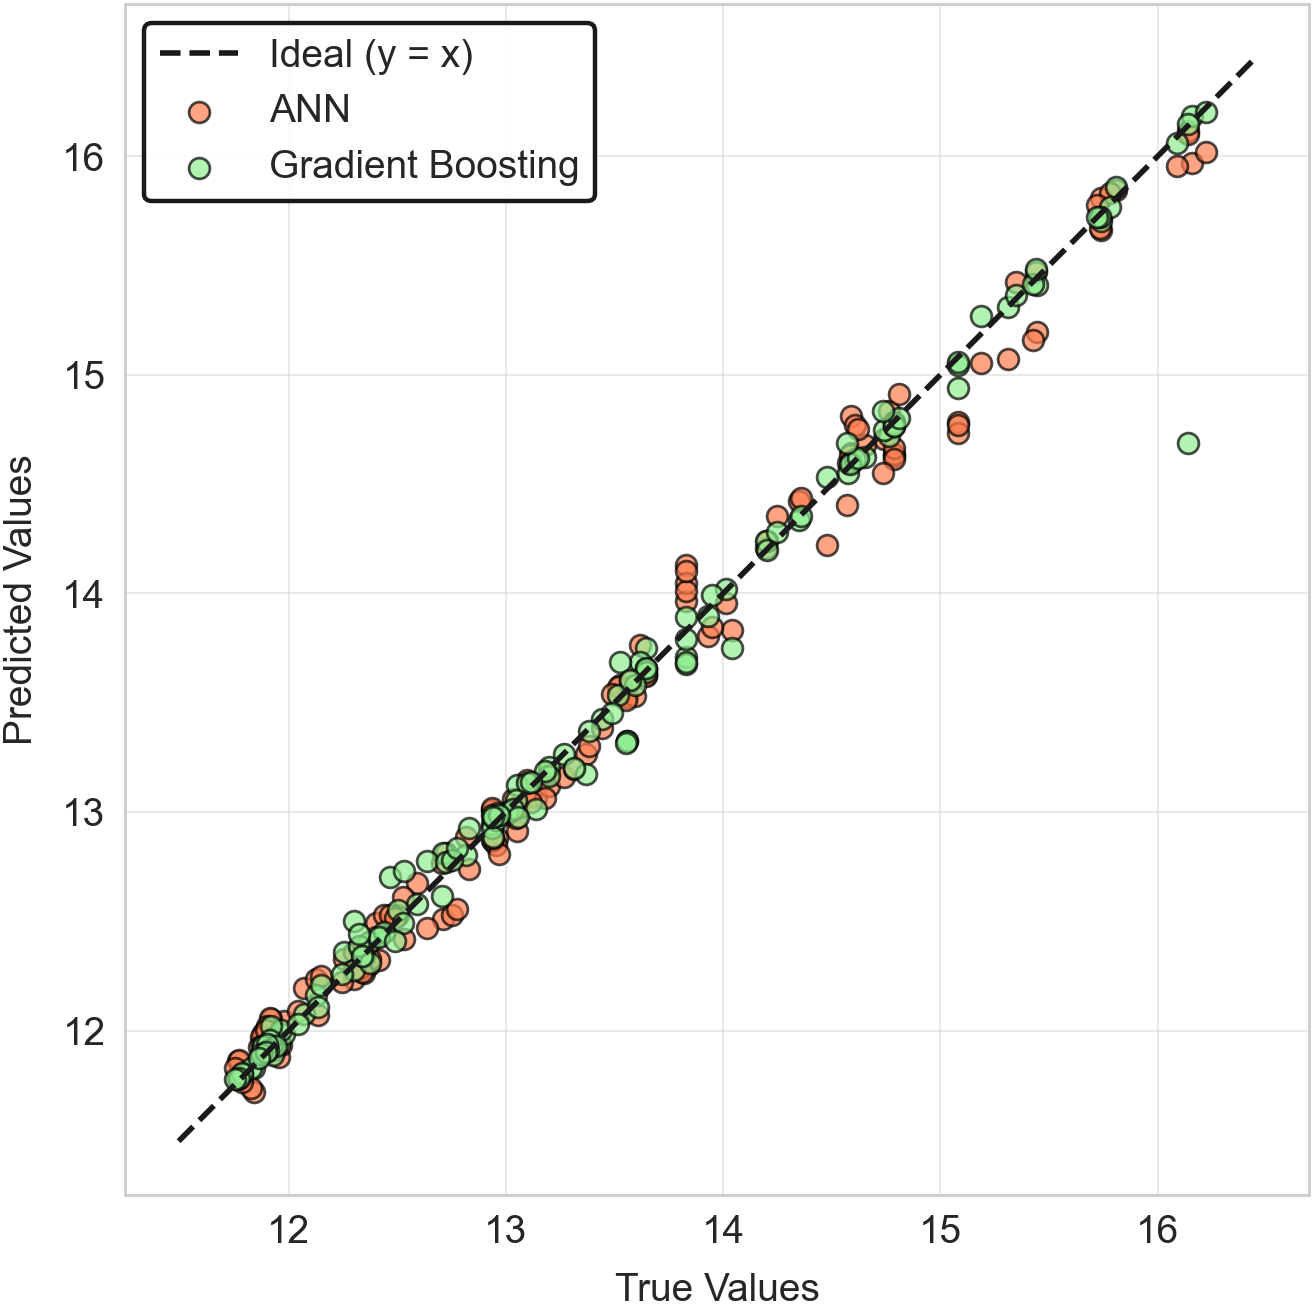

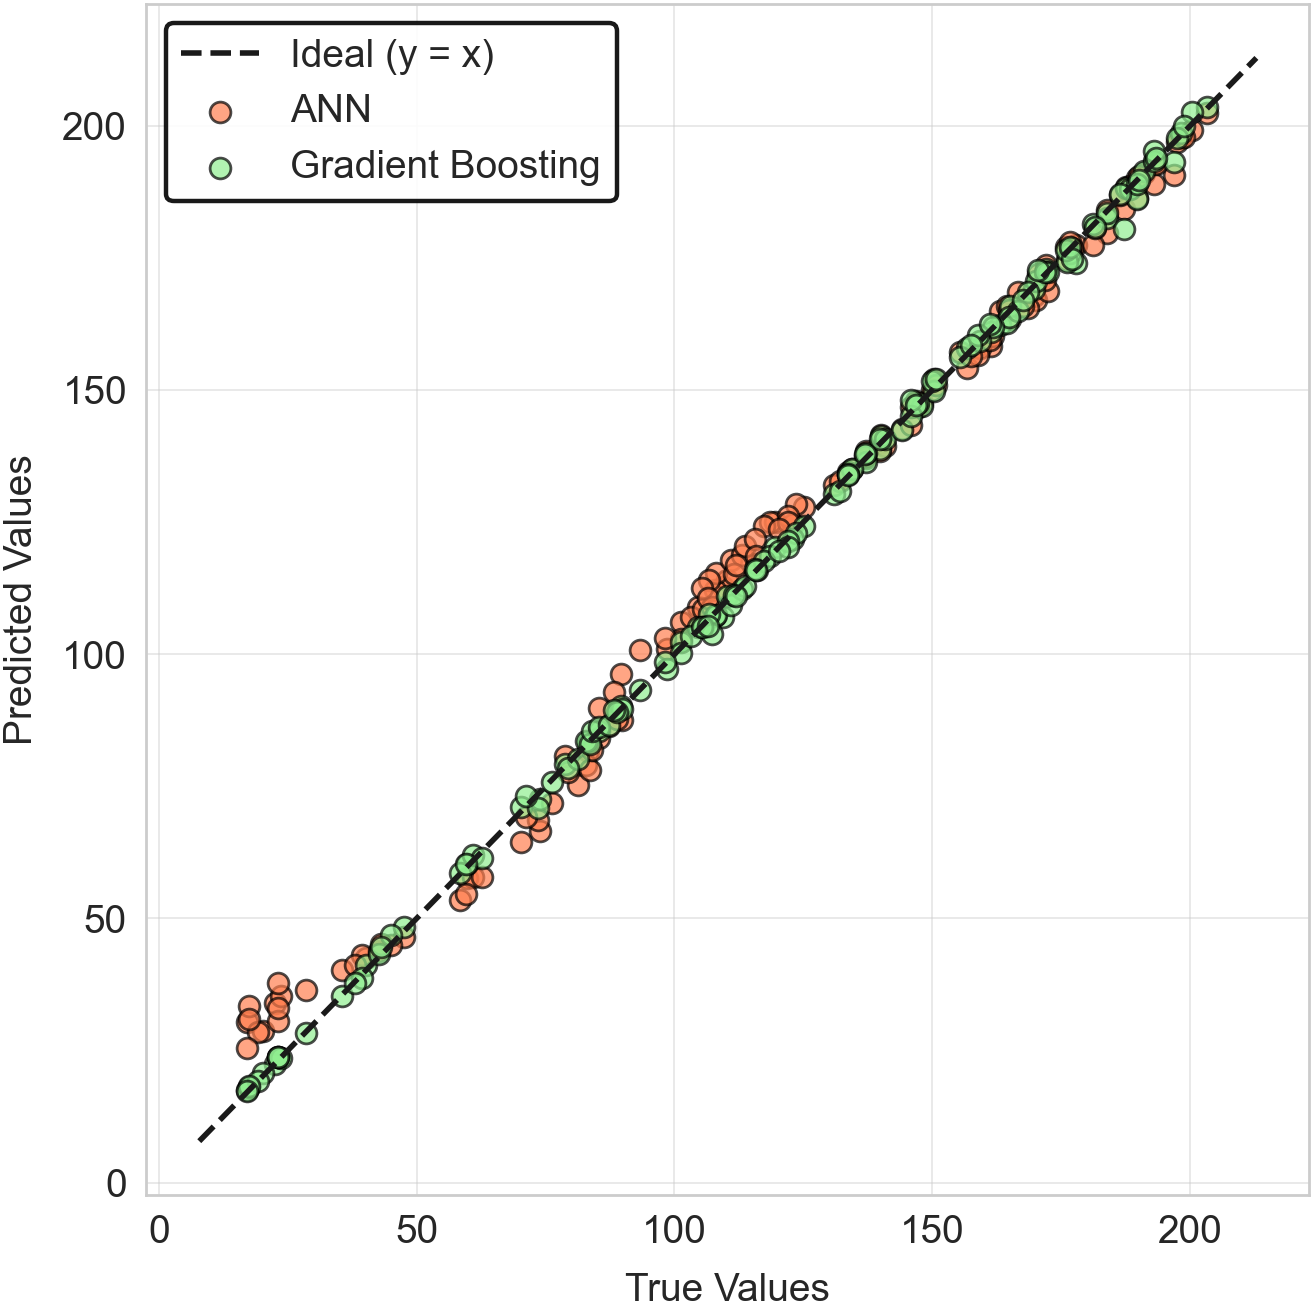

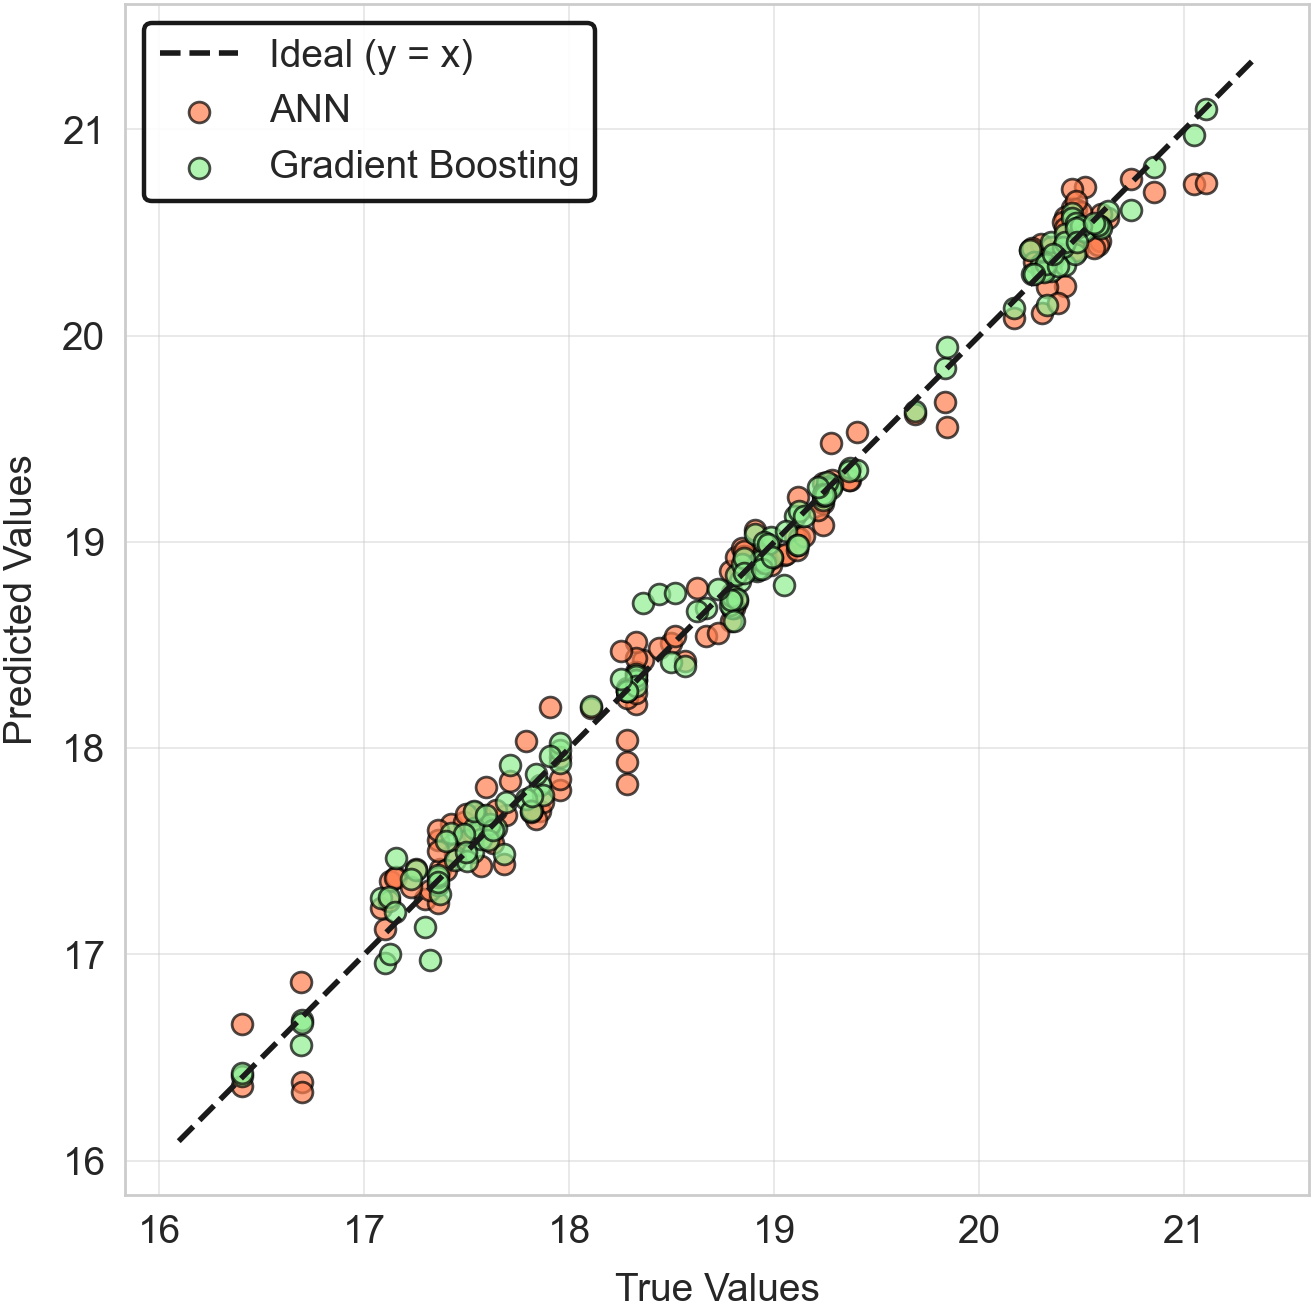

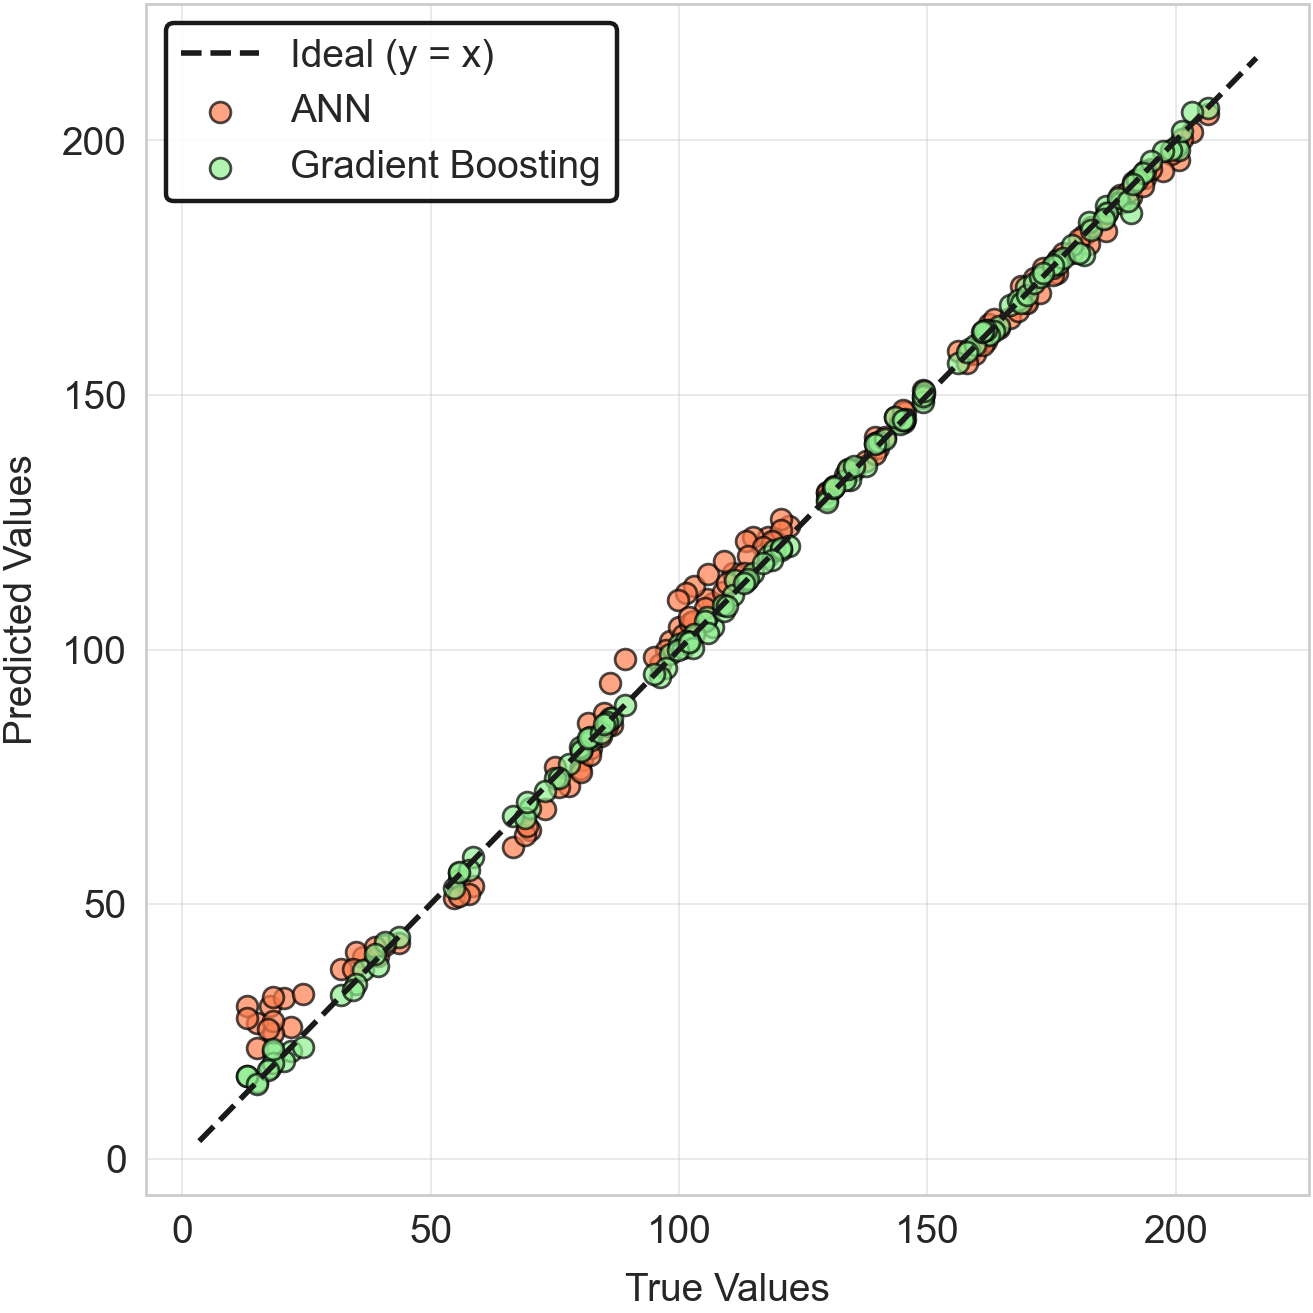

In [ ]:
targets = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]

for target in targets:
    actual = ann_actuals[target].values
    ann_pred = ann_predictions[target].values
    gb_pred = gb_predictions_df[target].values

    r2_ann = r2_score(actual, ann_pred)
    r2_gb = r2_score(actual, gb_pred)

    values = np.concatenate([actual, ann_pred, gb_pred])
    min_v, max_v = values.min(), values.max()
    margin = (max_v - min_v) * 0.05

    fig, ax = fig_mm(85, 85)
    ax.plot(
        [min_v - margin, max_v + margin],
        [min_v - margin, max_v + margin],
        "k--",
        label="Ideal (y = x)",
        lw=1.0,
    )
    ax.scatter(
        actual, ann_pred, alpha=0.7, s=14, color="#FF7F50", edgecolors="black", linewidths=0.5, label="ANN"
    )
    ax.scatter(
        actual, gb_pred, alpha=0.7, s=14, color="#90EE90", edgecolors="black", linewidths=0.5, label="Gradient Boosting"
    )
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.legend(frameon=True, edgecolor='black', framealpha=0.9)
    ax.grid(True, alpha=0.5)
    fig.savefig(f"plots/8_ann_gb_{target}_comparision.png")
    plt.show()

## 9. KDE plots of residuals for all four target variables predicted by the ANN model

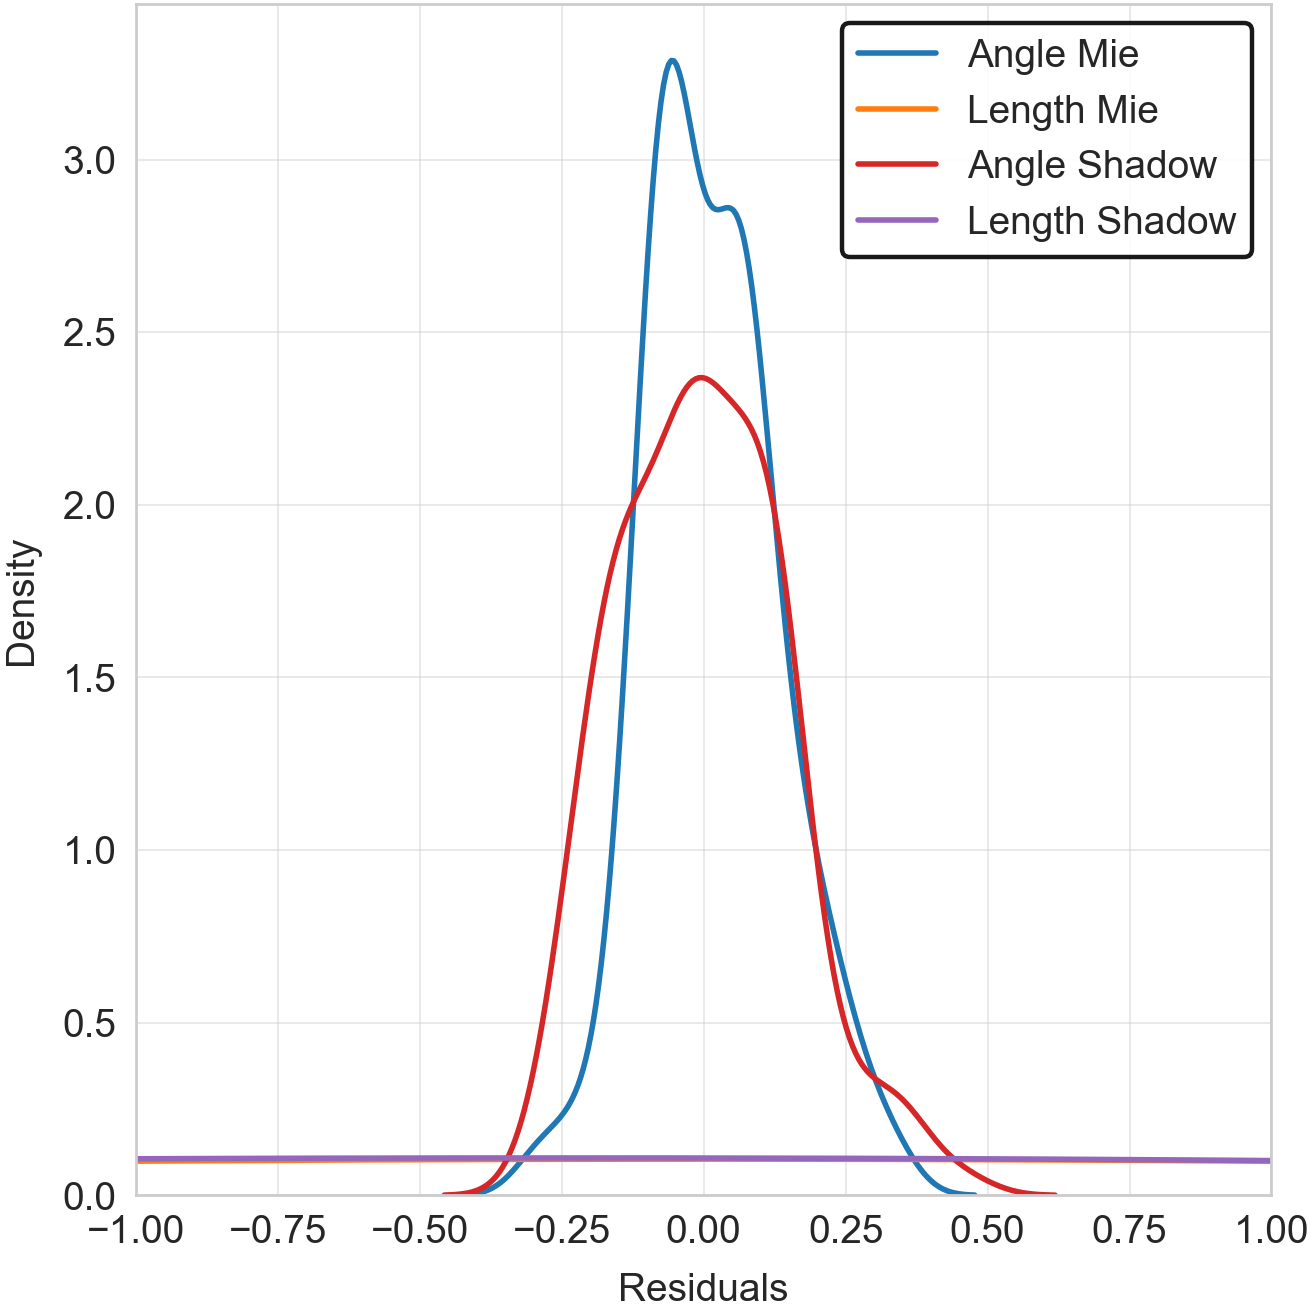

In [ ]:
residuals = {t: ann_actuals[t] - ann_predictions[t] for t in targets}
fig, ax = fig_mm(85, 85)
colors = ["#1f77b4", "#ff7f0e", "#d62728", "#9467bd"]
for i, t in enumerate(targets):
    sns.kdeplot(residuals[t], label=t.replace("_", " ").title(), color=colors[i])
ax.set_xlabel("Residuals")
ax.set_ylabel("Density")
ax.set_xlim(-1, 1)
ax.legend(frameon=True, edgecolor='black', framealpha=0.9)
ax.grid(True, alpha=0.5)
fig.savefig("plots/9_ann_residuals_kde.png")
plt.show()